# Embeddings con LSTM



In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import Counter
import random
import matplotlib.pyplot as plt
# from itertools import chain
# from pprint import pprint
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

In [2]:
cd ../helpers/

C:\Users\Usuario.000\Documents\Facultad\Git\2020-2\APIT-2020-2\ProyectoFinal\helpers


In [3]:
import boletines

In [4]:
cd ../Embeddings/

C:\Users\Usuario.000\Documents\Facultad\Git\2020-2\APIT-2020-2\ProyectoFinal\Embeddings


## Definición de constantes

In [5]:
# Número de GPUs disponibles. Usar 0 para modo CPU.
ngpu = 1

# Fuente de la cual queremos obtener los datos
source = 'corenlp'

# Semilla a usar en los generadores de números aleatorios
SEED = 42069
# SEED = random.randint(1, 10000) # En caso de requerir más resultados
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

print("Random Seed: ", SEED)

Random Seed:  42069


Selecciono el tipo de dispositivo a utilizar (gpu o cpu)

In [6]:
# Decide si queremos correr en gpu o cpu
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
device

device(type='cuda', index=0)

## Obtener corpus

In [7]:
uri = open('./../mongo_uri.txt', 'r', encoding='utf-8').read()

In [8]:
%%time
dict_sentences = boletines.sentences(uri, source)

Wall time: 3.72 s


Paso los tokens a minúsculas para reducir el tamaño del vocabulario

In [9]:
sentences = [[w.lower() for w in sent] for sent in dict_sentences['sentences']]
print(f'El corpus consta de {dict_sentences["count"]} enunciados.')
print(f'Tamaño mínimo: {dict_sentences["min"]} tokens.')
print(f'Tamaño máximo: {dict_sentences["max"]} tokens.')
print(f'Tamaño promedio: {dict_sentences["avg"]} tokens.')
print(f'Desviación estándar: {dict_sentences["std"]} tokens.')

El corpus consta de 6583 enunciados.
Tamaño mínimo: 3 tokens.
Tamaño máximo: 131 tokens.
Tamaño promedio: 39.80191402096309 tokens.
Desviación estándar: 18.703258140465145 tokens.


Imprimo algunas oraciones de muestra

In [10]:
step = max(dict_sentences["count"]//5, 1)
print('\n\n'.join(
    [ f"{i+1}.- {' '.join(sent)}" for i, sent in enumerate(sentences[::step]) ]
))

1.- el candidato de la coalición todos por méxico a la presidencia de la república , josé antonio meade , presentó la coordinación de atención ciudadana y el buzón del candidato .

2.- un méxico sin impunidad , en el que el que la hace , la tiene que pagar .

3.- asegura que se podría reunir con los de la mafia del poder " siempre y cuando se respete el estado de derecho " .

4.- en colima , donde más de 3 mil personas lo recibieron efusivamente para demostrarle su apoyo , el candidato a la presidencia de la república aseveró que recuperar la paz hoy fundamental , pues no tiene paz quien no puede salir a la calle con tranquilidad , pero tampoco quien no sabe qué va a comer al día siguiente .

5.- en chiapas , dijo , tenemos el conocimiento de la gente que conoce la tierra y se comprometió a apoyar a agricultores , ganaderos cuando presente el plan de desarrollo de la región .

6.- llama amlo a los ciudadanos a ir todos a votar el primero de julio para ganar de manera contundente .


## Indexar Corpus

Cuento los tokens en todas las oraciones e imprimo algunos de ellos.

In [11]:
%%time
freq = sum([Counter(sent) for sent in sentences], Counter())

Wall time: 28.2 s


In [12]:
n_tipos = len(freq.keys())
print(f'Número de tipos: {n_tipos}')
print(freq.most_common()[::max(n_tipos//25, 1)])

Número de tipos: 12789
[(',', 19112), ('poco', 52), ('alegría', 24), ('cancún', 15), ('movilidad', 10), ('valles', 8), ('erario', 6), ('vigor', 5), ('arizpe', 4), ('amozoc', 3), ('resucitará', 3), ('movilizar', 2), ('rehén', 2), ('traducirse', 2), ('costilla', 2), ('brindará', 1), ('flexibles', 1), ('contemplen', 1), ('plantación', 1), ('acaparadores', 1), ('banqueros', 1), ('precipitar', 1), ('responsabilizarlo', 1), ('escuché', 1), ('calumnió', 1), ('postulado', 1)]


Agrego un diccionario para pasar de palabra a índice numérico

In [13]:
w_to_ix = {
    w : ix
    for ix, (w, freq) in enumerate(freq.most_common())
    if freq > 1 # No toma en cuenta los hapax
}

In [14]:
vocab_size = len(w_to_ix)
vocab_size

7471

Agrego símbolos de inicio y fin de cadena, así como el token <UNK\> para palabras no vistas

In [15]:
BOS = '<BOS>'
EOS = '<EOS>'
UNK = '<UNK>'

ixBOS = vocab_size
ixEOS = vocab_size + 1
ixUNK = vocab_size + 2

In [16]:
w_to_ix[BOS] = ixBOS
w_to_ix[EOS] = ixEOS
w_to_ix[UNK] = ixUNK

Calculo el nuevo tamaño del vocabulario después de agregar 3 tokens

In [17]:
vocab_size = len(w_to_ix)
vocab_size

7474

Creo el diccionario inverso, para convertir de índices a palabras

In [18]:
ix_to_w = [ w for w, ix in w_to_ix.items() ]

Guardo las etiquetas en un archivo txt

In [19]:
with open(f'word_labels_{source}.txt', 'w', encoding='utf-8') as f:
    f.write('\n'.join(ix_to_w))

Indexo todo el corpus

In [20]:
def w_to_index_unk(w):
    """
    Le asigna el token UNK a palabras que no aparezcan en el corpus
    """
    try:
        return w_to_ix[w] 
    except KeyError:
        return ixUNK

In [21]:
sentences_ix = [
    # Le agrego el inicio y fin de caracter a los enunciados
    [ixBOS] + [ w_to_index_unk(w) for w in sent ] + [ixEOS] 
    for sent in sentences
]

X = [ np.asarray(sent[:-1]) for sent in sentences_ix ]
Y = [ np.asarray(sent[1:]) for sent in sentences_ix ] 

print('Ejemplos X')
print(X[:3])
print('Ejemplos Y')
print(Y[:3])

Ejemplos X
[array([7471,    5,   26,    1,    3,   38,   33,   16,   20,    4,    3,
         52,    1,    3,   71,    0,   48,   50,   34,    0,  536,    3,
        497,    1,  298,  960,    7,    5, 5481,   15,   26,    6]), array([7471,    4,  437,    1,  301, 2854,    0,   34,    7,   23,  716,
          0,  961,  873,    0, 7473,   17,  190,    0, 5482,    0, 3659,
          7,  698,    1,    3,  441,    6]), array([7471,    5,  442,    1,  298,  960,  223, 7473,   16,  112, 7473,
          0,  123, 1197,    5,  256,    1,   31,   15,   26,    1,    3,
         38,   33,   16,   20,    7, 4362, 7473,    8,    3,  427,    1,
         19,   32,   27, 1330,    7, 2855,    0,   85,   11, 5483,   17,
       3660,    7,   11, 5484,   17, 3201,    6])]
Ejemplos Y
[array([   5,   26,    1,    3,   38,   33,   16,   20,    4,    3,   52,
          1,    3,   71,    0,   48,   50,   34,    0,  536,    3,  497,
          1,  298,  960,    7,    5, 5481,   15,   26,    6, 7472]), array([   4,

Separo el corpus en conjunto de evaluación y pruebas

In [58]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.30)

Calculo las longitudes del conjunto de entrenamiento y validación

In [94]:
N_train = len(X_train)
N_val = len(X_val)
print(N_train)
print(N_val)

4608
1975


Mando los vectores de entrada y salida a tensores en gpu

In [60]:
def to_pytorch_tensor(list_of_lists):
    return [
        torch.from_numpy(l).long().to(device)
        for l in list_of_lists
    ]

In [61]:
X_train = to_pytorch_tensor(X_train)
Y_train = to_pytorch_tensor(Y_train)

X_val = to_pytorch_tensor(X_val)
Y_val = to_pytorch_tensor(Y_val)

## Modelo

### 1. Capa de embedding

### 2. Capa oculta

### 3. Capa de salida

Defino las variables para la red neuronal

In [66]:
# Dimensión de entrada (one-hot), tamaño del vocabulario
D_in = vocab_size

# Dimensión de la capa de embedding
D_emb = 64 # 32

# Dimensión de la capa lstm
D_lstm = 32 # 16

# Dimensión de la capa de salida
D_out = D_in

# Épocas de entrenamiento
num_epochs = 350

# Learning rate
lr =  0.1

In [95]:
class Model(nn.Module):
    def __init__(self, ngpu, D_in, D_emb, D_lstm, D_out):
        super(Model, self).__init__()
        self.ngpu = ngpu
        self.embedding = nn.Embedding(num_embeddings=D_in, embedding_dim=D_emb)#, padding_idx=0)
        self.lstm = nn.LSTM(input_size=D_emb, hidden_size=D_lstm) #, bias=True)#, batch_first=True)
        self.linear = nn.Linear(in_features=D_lstm, out_features=D_out) #, bias=True)

    def forward(self, sentence):
        T = len(sentence)
        embeddings = self.embedding(sentence).view(T, 1, -1)
        lstm_out, (ht, ct) = self.lstm(embeddings)
        lstm_out = lstm_out.view(T, -1)
        preact_out = self.linear(lstm_out).view(T, -1)
        
        return F.log_softmax(preact_out, dim=1)
    
    def pred(self, sentence):
        with torch.no_grad():
            out = self.forward(sentence)
            pred = torch.argmax(out, dim=1)
        return pred

In [96]:
model = Model(ngpu, D_in, D_emb, D_lstm, D_out).to(device)
model

Model(
  (embedding): Embedding(7474, 64)
  (lstm): LSTM(64, 32)
  (linear): Linear(in_features=32, out_features=7474, bias=True)
)

Verisimilitud logarítmica negativa como función de coste y SGD como optimizador

In [97]:
criterion = nn.NLLLoss()
criterion.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

### Entrenamiento

In [98]:
%%time
train_loss_hist = np.zeros(num_epochs+1)
val_loss_hist = np.zeros(num_epochs+1)

train_loss_hist[-1] = np.inf
val_loss_hist[-1] = np.inf

best_model = None

train_data = list(zip(X_train, Y_train))
val_data = list(zip(X_val, Y_val))

for epoch in tqdm(range(num_epochs)):
    
    # Entrenamiento
    model.train()
    train_loss = 0
    random.shuffle(train_data)
    for x, y in train_data:
        # Limpiamos gradientes acumulados
        model.zero_grad()

        # Forward
        out = model(x)
     
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= N_train
    train_loss_hist[epoch] = train_loss
    
    # Validación
    model.eval()
    val_loss = 0
    random.shuffle(val_data)
    for x, y in val_data:
        out = model(x)     
        loss = criterion(out, y)
        val_loss += loss.item()
    val_loss /= N_val
    val_loss_hist[epoch] = val_loss
    
    if epoch%20 == 0:
        tqdm.write(f'Epoch {epoch+1:3}.\ttrain_loss: {train_loss:2.6f}\tval_loss: {val_loss:2.6f}')
    if val_loss < val_loss_hist[epoch-1]:
        best_model = model.state_dict()

Epoch   1.	train_loss: 6.070811	val_loss: 5.533875
Epoch  21.	train_loss: 4.414260	val_loss: 4.610984
Epoch  41.	train_loss: 4.129657	val_loss: 4.473078
Epoch  61.	train_loss: 3.949935	val_loss: 4.421951
Epoch  81.	train_loss: 3.816023	val_loss: 4.392621
Epoch 101.	train_loss: 3.709263	val_loss: 4.391178
Epoch 121.	train_loss: 3.624512	val_loss: 4.392777
Epoch 141.	train_loss: 3.550025	val_loss: 4.402012
Epoch 161.	train_loss: 3.488211	val_loss: 4.415721
Epoch 181.	train_loss: 3.433932	val_loss: 4.434457
Epoch 201.	train_loss: 3.387185	val_loss: 4.443446
Epoch 221.	train_loss: 3.353932	val_loss: 4.462370
Epoch 241.	train_loss: 3.309478	val_loss: 4.478090
Epoch 261.	train_loss: 3.282747	val_loss: 4.505704
Epoch 281.	train_loss: 3.258210	val_loss: 4.507767
Epoch 301.	train_loss: 3.225943	val_loss: 4.524753
Epoch 321.	train_loss: 3.213414	val_loss: 4.539252
Epoch 341.	train_loss: 3.181627	val_loss: 4.544644

Wall time: 2h 27min 3s


In [118]:
tl = [6.070811, 4.414260, 4.129657, 3.949935, 3.816023, 3.709263, 3.225943, 3.213414, 3.181627]
vl = [5.533875, 4.610984, 4.473078, 4.421951, 4.392621, 4.391178, 4.524753, 4.539252, 4.544644]

for tli, vli in zip(tl, vl):
    print(2*tli*vli/(tli+vli))

5.789921282251841
4.510477995240904
4.294512820456751
4.172636613347339
4.084071075876357
4.021517861018678
3.7665250364816267
3.762962554127316
3.7429083333442486


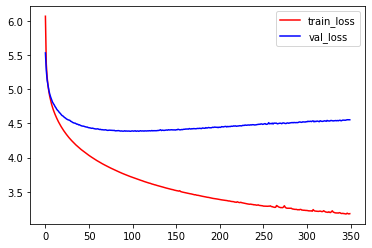

In [104]:
plt.figure()

plt.plot(train_loss_hist[:-1], color='red', label='train_loss')
plt.plot(val_loss_hist[:-1], color='blue', label='val_loss')
plt.legend()

plt.show()

In [115]:
best_train_epoch = train_loss_hist.argmin()+1
best_val_epoch = val_loss_hist.argmin()+1

print(f'Mejor resultado en corpus de entrenamiento en época {best_train_epoch}')
print(f'Mejor resultado en corpus de validación en época {best_val_epoch}')

Mejor resultado en corpus de entrenamiento en época 345
Mejor resultado en corpus de validación en época 105


In [42]:
def print_ix_sentence(sentence):
    print(' '.join(ix_to_w[ix] for ix in sentence.data))

In [110]:
def torch_ix_sentence_to_w(sentence):
    return [ix_to_w[ix] for ix in sentence.data]

In [111]:
print(f"{'x_i':>16}{'x_i':>16}{'x_i':>16}")

             x_i             x_i             x_i


In [114]:
with torch.no_grad():
    # TODO: Armar corpus de prueba para evaluar resultados después de entrenamiento
    for sentence, y in val_data: 
        print('===================================================')
        pred = model.pred(sentence)
        sent_words = torch_ix_sentence_to_w(sentence) # Input
        y_hat_words = torch_ix_sentence_to_w(pred) # Datos predichos
        y_words = torch_ix_sentence_to_w(y) # Datos reales
        
        print(f"{'x_i':>16}{'y_hat_i':>16}{'y_i':>16}")
        for x_i, y_hat_i, y_i in zip(sent_words, y_hat_words, y_words):
            print(f"{x_i:>16}{y_hat_i:>16}{y_i:>16}")
        print('===================================================\n')

        

             x_i         y_hat_i             y_i
           <BOS>               "            josé
            josé         antonio         antonio
         antonio           meade           meade
           meade        presentó           <UNK>
           <UNK>           <UNK>               a
               a              un              la
              la           gente       población
       población               y        observar
        observar              la             las
             las         mujeres         señales
         señales               ,              de
              de             los          riesgo
          riesgo               "              en
              en              la            esta
            esta          región        elección
        elección               .               y
               y              de           poner
           poner               a               a
               a             los          méxico
          méxico    

             del          carmen        gabinete
        gabinete               ,    presidencial
    presidencial               ,               y
               y            dijo         líderes
         líderes              de              de
              de         texcoco             los
             los             que        sectores
        sectores              de        priistas
        priistas           <UNK>               ,
               ,            pero            josé
            josé         antonio         antonio
         antonio           meade           meade
           meade               ,           habló
           habló              de              de
              de              la              lo
              lo             que             que
             que            gana            será
            será              el              su
              su        gobierno      plataforma
      plataforma               y              de
              de    

             x_i         y_hat_i             y_i
           <BOS>               "               a
               a              la              la
              la        pregunta        pregunta
        pregunta              de              de
              de             los             los
             los      reporteros      reporteros
      reporteros           sobre            cómo
            cómo              si     reconciliar
     reconciliar              en               a
               a             los          méxico
          méxico               y               ,
               ,          porque           lópez
           lópez         obrador         obrador
         obrador       respondió       respondió
       respondió             que             que
             que              no         llamará
         llamará               a               a
               a             los           todos
           todos             los             los
             los    

             x_i         y_hat_i             y_i
           <BOS>               "              de
              de              la            cara
            cara               a               a
               a             las             las
             las       encuestas      elecciones
      elecciones               ,             del
             del          estado               1
               1              de              de
              de           julio           julio
           julio               .               ,
               ,          porque            josé
            josé         antonio         antonio
         antonio           meade           meade
           meade               ,         exhortó
         exhortó               a               a
               a            cabo             los
             los         jóvenes       presentes
       presentes               ,               a
               a             los        defender
        defender    

             x_i         y_hat_i             y_i
           <BOS>               "               a
               a              la              la
              la        pregunta        pregunta
        pregunta              de              de
              de             los             los
             los      reporteros      reporteros
      reporteros           sobre            sale
            sale              en              la
              la           gente          última
          última               "        encuesta
        encuesta              de              de
              de              la           <UNK>
           <UNK>            para               a
               a              la            días
            días               ,              de
              de           <UNK>              la
              la           gente        elección
        elección             del               ,
               ,             que           usted
           usted    

             x_i         y_hat_i             y_i
           <BOS>               "              se
              se     comprometió       considera
       considera       coalición         primera
         primera        infancia        infancia
        infancia               a              la
              la         reforma           etapa
           etapa             que             que
             que              se              va
              va               a           desde
           desde               a              la
              la           gente      concepción
      concepción               ,               y
               y           <UNK>           hasta
           hasta              su             los
             los       mexicanos               5
               5            años            años
            años               ,              de
              de          méxico            edad
            edad               ,               ,
               ,    

             x_i         y_hat_i             y_i
           <BOS>               "         criticó
         criticó             que               a
               a              la             qué
             qué           <UNK>          vienen
          vienen               y               a
               a             los        presumir
        presumir               ,             los
             los       mexicanos     tecnócratas
     tecnócratas               ,              su
              su        gobierno          modelo
          modelo       económico              de
              de       seguridad            este
            este          sector         periodo
         periodo             que      neoliberal
      neoliberal               .               ,
               ,              la            pero
            pero              no               "
               "              no              no
              no              se        queremos
        queremos    

             que              se             los
             los           <UNK>       mexicanos
       mexicanos              no              no
              no              se              se
              se           <UNK>          tienen
          tienen            agua             que
             que              se        resignar
        resignar              la               ,
               ,             con               y
               y              no             que
             que              se              la
              la           gente      aplicación
      aplicación              de              de
              de           <UNK>              la
              la           mafia             ley
             ley               ,              no
              no              se            debe
            debe              de        depender
        depender             que             del
             del             pan      gobernante
      gobernante    

             x_i         y_hat_i             y_i
           <BOS>               "               "
               "              no           vamos
           vamos               a               a
               a           ganar           ganar
           ganar               "          porque
          porque           vamos           hemos
           hemos           <UNK>           hecho
           hecho               a              la
              la             paz           tarea
           tarea               ,               ,
               ,              no              no
              no              se       solamente
       solamente             los              en
              en              el              la
              la          ciudad         campaña
         campaña              de               ,
               ,              la           hemos
           hemos           <UNK>           hecho
           hecho               y              la
              la    

             x_i         y_hat_i             y_i
           <BOS>               "         alfonso
         alfonso            romo            romo
            romo             del              se
              se           <UNK>            está
            está           <UNK>       reuniendo
       reuniendo              de             con
             con             las     empresarios
     empresarios               ,            para
            para             que      aclararles
      aclararles              de              de
              de         familia             que
             que              la               "
               "              no        nosotros
        nosotros              no              no
              no              se         estamos
         estamos              en              en
              en              el          contra
          contra              de              de
              de              la              la
              la    

             x_i         y_hat_i             y_i
           <BOS>               "       manifestó
       manifestó             que             que
             que              se        llegando
        llegando              en              al
              al            país        gobierno
        gobierno              de           <UNK>
           <UNK>               ,              el
              el          sueldo         escrito
         escrito             del              de
              de           <UNK>            josé
            josé         antonio           maría
           maría           <UNK>         morelos
         morelos            para               y
               y           <UNK>           pavón
           pavón               ,               "
               "               ,             los
             los      candidatos    sentimientos
    sentimientos               a              de
              de              la              la
              la    

             las         mujeres           ideas
           ideas               y               ,
               ,              no              el
              el       candidato         derecho
         derecho               a               a
               a              la        disentir
        disentir               ,               ,
               ,              no        libertad
        libertad               y           <UNK>
           <UNK>            para               ,
               ,          porque               y
               y             que            como
            como              se           decía
           decía              un              un
              un        gobierno         liberal
         liberal              de            puro
            puro               .         ignacio
         ignacio               ,         ramírez
         ramírez               ,              el
              el           <UNK>      nigromante
      nigromante    

             x_i         y_hat_i             y_i
           <BOS>               "          indicó
          indicó             que             que
             que              se              el
              el        gobierno      gobernador
      gobernador              de              de
              de              la         hidalgo
         hidalgo               ,              es
              es             que            como
            como              de          miguel
          miguel           ángel           ángel
           ángel           <UNK>           yunes
           yunes             que               ,
               ,          porque      gobernador
      gobernador               ,              de
              de          méxico        veracruz
        veracruz               ,               y
               y              se          añadió
          añadió             que             que
             que              se           fayad
           fayad    

             x_i         y_hat_i             y_i
           <BOS>               "               "
               "              no              el
              el       candidato  comportamiento
  comportamiento              de             del
             del          frente      presidente
      presidente              de              es
              es             que             muy
             muy      importante      importante
      importante               ,               ,
               ,          porque             por
             por             eso         ejemplo
         ejemplo              de              no
              no              se            todo
            todo              el              se
              se           <UNK>           puede
           puede           hacer           hacer
           hacer              un             con
             con              un          dinero
          dinero             del               ,
               ,    

             x_i         y_hat_i             y_i
           <BOS>               "               "
               "              no              no
              no              se         podemos
         podemos              es              ni
              ni              de         tenemos
         tenemos              de             que
             que              no  acostumbrarnos
  acostumbrarnos               a               a
               a             los           vivir
           vivir             con             con
             con              el           miedo
           miedo               ,               ,
               ,              el              en
              en              la         nuestro
         nuestro            país        gobierno
        gobierno               ,           vamos
           vamos               a               a
               a           ganar        prevenir
        prevenir               y               ,
               ,    

             x_i         y_hat_i             y_i
           <BOS>               "      detallaron
      detallaron             que             que
             que              la             las
             las        familias        empresas
        empresas              es             que
             que              se           <UNK>
           <UNK>           <UNK>              el
              el           <UNK>         terreno
         terreno            para               a
               a              la          lomelí
          lomelí               ,          fueron
          fueron               a           <UNK>
           <UNK>               ,             por
             por              la              el
              el           <UNK>    departamento
    departamento              de             del
             del             pri           <UNK>
           <UNK>               ,              de
              de              la         estados
         estados    

             x_i         y_hat_i             y_i
           <BOS>               "               a
               a              la        pregunta
        pregunta              se              de
              de              su             los
             los     empresarios      reporteros
      reporteros             qué           sobre
           sobre              su              si
              si             que              la
              la           <UNK>    procuraduría
    procuraduría               y         general
         general               .              de
              de      excelencia              la
              la      secretaría       república
       república               .            debe
            debe              de               o
               o             sea              no
              no              es      intervenir
      intervenir              en              en
              en              el            este
            este    

             x_i         y_hat_i             y_i
           <BOS>               "           <UNK>
           <UNK>             que             que
             que             los               a
               a              la         hidalgo
         hidalgo         merecen              se
              se           <UNK>              le
              le            dijo           <UNK>
           <UNK>              el              de
              de           <UNK>        demagogo
        demagogo               ,               ,
               ,             que              al
              al           mismo      presidente
      presidente              de          juárez
          juárez              se         también
         también              se         padeció
         padeció               a              de
              de             que  discriminación
  discriminación               a               y
               y              no         racismo
         racismo    

             x_i         y_hat_i             y_i
           <BOS>               "              el
              el       candidato       aspirante
       aspirante    presidencial    presidencial
    presidencial            dijo         reiteró
         reiteró              su              su
              su      compromiso      compromiso
      compromiso              de              de
              de        cancelar       triplicar
       triplicar              el              el
              el        programa     presupuesto
     presupuesto              de       destinado
       destinado               .               a
               a             los             los
             los         jóvenes   emprendedores
   emprendedores               ,            para
            para              el             que
             que              se            sean
            sean             los              un
              un          cambio           motor
           motor    

             x_i         y_hat_i             y_i
           <BOS>               "             con
             con              el           estas
           estas        acciones        acciones
        acciones               a               ,
               ,             los           meade
           meade        refrendó        refrendó
        refrendó             que              su
              su      compromiso      compromiso
      compromiso              de            para
            para             que       encabezar
       encabezar              un              un
              un        gobierno        gobierno
        gobierno              de         cercano
         cercano               a               a
               a             los              la
              la           gente           gente
           gente               ,               y
               y           <UNK>               a
               a             los              la
              la    

             x_i         y_hat_i             y_i
           <BOS>               "           desde
           desde              la        cárdenas
        cárdenas               ,               ,
               ,          porque         tabasco
         tabasco               ,         recordó
         recordó             que              el
              el             que           <UNK>
           <UNK>              de             por
             por              la              la
              la           <UNK>      democracia
      democracia               ,               ,
               ,              el           donde
           donde              se           <UNK>
           <UNK>              el           desde
           desde              el         tabasco
         tabasco               ,           hasta
           hasta              su              la
              la      corrupción          ciudad
          ciudad               .              de
              de    

             x_i         y_hat_i             y_i
           <BOS>               "              en
              en              el      entrevista
      entrevista               ,               ,
               ,              el           lópez
           lópez         obrador         obrador
         obrador            dijo         detalló
         detalló             que             que
             que              la             los
             los       mexicanos              de
              de              la              la
              la           mafia          cúpula
          cúpula             del              se
              se           <UNK>       reunieron
       reunieron              la              en
              en              la           valle
           valle              de              de
              de             los           bravo
           bravo               ,               ,
               ,             que           donde
           donde    

             x_i         y_hat_i             y_i
           <BOS>               "         comentó
         comentó             que             que
             que              se              ya
              ya              no              no
              no              se           habrá
           habrá     gasolinazos             las
             las               y       pensiones
       pensiones              en     millonarias
     millonarias             que               a
               a             los             los
             los         jóvenes              ex
              ex     presidentes     presidentes
     presidentes               ,               ,
               ,          porque              se
              se           <UNK>        quitarán
        quitarán              la             los
             los       mexicanos               5
               5              de             mil
             mil        millones        millones
        millones    

             con              la           todos
           todos             los             los
             los       mexicanos     empresarios
     empresarios               .               ,
               ,             que             con
             con             los             los
             los         jóvenes    comerciantes
    comerciantes              de               ,
               ,              no             con
             con             los             los
             los        partidos     empresarios
     empresarios               y              de
              de          méxico             los
             los        partidos      municipios
      municipios              de               ,
               ,          porque              de
              de             las             los
             los        maestros         estados
         estados          unidos             del
             del          carmen            país
            país    

             x_i         y_hat_i             y_i
           <BOS>               "          agregó
          agregó             que             que
             que               ,             les
             les            dará           cobra
           cobra           <UNK>           mucho
           mucho               ,               ,
               ,          porque             les
             les              va           están
           están              en         robando
         robando               y               ,
               ,           <UNK>             los
             los       servicios     publicistas
     publicistas              de          cobran
          cobran              la              en
              en              el         dólares
         dólares               ,               ,
               ,              no              no
              no              se              es
              es              el           pesos
           pesos    

             x_i         y_hat_i             y_i
           <BOS>               "         comentó
         comentó             que             que
             que              se              le
              le           <UNK>      informaron
      informaron               .             que
             que              se           meade
           meade            dijo         convocó
         convocó               a               a
               a             los             una
             una           <UNK>     conferencia
     conferencia              de              de
              de      desarrollo          prensa
          prensa               ,            para
            para             que           decir
           decir             que             que
             que              se              no
              no              se             son
             son             los            tres
            tres           actos               ,
               ,    

             x_i         y_hat_i             y_i
           <BOS>               "          andrés
          andrés          manuel          manuel
          manuel           lópez           lópez
           lópez         obrador         obrador
         obrador         aseguró         expresó
         expresó             que             que
             que              se              el
              el        gobierno      distintivo
      distintivo              de             del
             del        gobierno           nuevo
           nuevo      aeropuerto        gobierno
        gobierno     democrático              es
              es              el             que
             que              el              se
              se           <UNK>         acabará
         acabará             con             con
             con              la              la
              la      corrupción      corrupción
      corrupción               ,               ,
               ,    

             x_i         y_hat_i             y_i
           <BOS>               "               a
               a              la              la
              la        pregunta        pregunta
        pregunta              de              de
              de             los             los
             los      reporteros      reporteros
      reporteros           sobre           sobre
           sobre             que             que
             que             los              la
              la           <UNK>        cantante
        cantante              no         belinda
         belinda              el            dijo
            dijo             que             que
             que              se            ganó
            ganó              el              el
              el       candidato          debate
          debate               y               ,
               ,              no           lópez
           lópez         obrador         obrador
         obrador    

             x_i         y_hat_i             y_i
           <BOS>               "              en
              en              el            otro
            otro            tema            tema
            tema               ,               ,
               ,          andrés           lópez
           lópez         obrador         obrador
         obrador         expresó        insistió
        insistió             que             que
             que              no              se
              se           <UNK>           tiene
           tiene             que             que
             que             ver   transparentar
   transparentar           <UNK>            todo
            todo              el              lo
              lo             que     relacionado
     relacionado              al             con
             con              la              la
              la      corrupción    construcción
    construcción              de             del
             del    

             x_i         y_hat_i             y_i
           <BOS>               "              el
              el       candidato        gobierno
        gobierno              de              va
              va               a               a
               a           ganar     representar
     representar               a               a
               a             los               :
               :            amlo      campesinos
      campesinos               .               ,
               ,             que         obreros
         obreros               y               ,
               ,              no        maestros
        maestros             que               ,
               ,               a     integrantes
     integrantes               y              de
              de              la             las
             las         mujeres          clases
          clases               a          medias
          medias               ,               ,
               ,    

             x_i         y_hat_i             y_i
           <BOS>               "           pidió
           pidió               a           votar
           votar             por             por
             por              la           feliz
           feliz             por         salgado
         salgado               a       macedonio
       macedonio               y               y
               y           <UNK>         nestora
         nestora         salgado         salgado
         salgado              en               ,
               ,         jalisco       candidata
       candidata               a              al
              al          frente          senado
          senado      presidente               ,
               ,             los           quien
           quien              se              ha
              ha       recorrido            sido
            sido              su             muy
             muy           buena           <UNK>
           <UNK>    

             x_i         y_hat_i             y_i
           <BOS>               "            josé
            josé         antonio         antonio
         antonio           meade           meade
           meade        presentó         comentó
         comentó             que             que
             que              se             los
             los           <UNK>       mexicanos
       mexicanos             los         estamos
         estamos        luchando          frente
          frente               a               a
               a              un             una
             una           <UNK>        elección
        elección              de         difícil
         difícil             que               ,
               ,          porque              en
              en              el              la
              la          ciudad             que
             que              se             nos
             nos           <UNK>            guía
            guía    

             x_i         y_hat_i             y_i
           <BOS>               "              en
              en              el              su
              su         mensaje          cierre
          cierre              de              de
              de         campaña         campaña
         campaña              en              en
              en              el         tierras
         tierras               ,           <UNK>
           <UNK>               ,               ,
               ,              ni           meade
           meade            dijo            dijo
            dijo             que             que
             que              se              en
              en              el            esta
            esta        elección         entidad
         entidad              es               y
               y              en              en
              en              la            todo
            todo           lugar              el
              el    

             x_i         y_hat_i             y_i
           <BOS>               "        arropado
        arropado             que             por
             por              su           miles
           miles              de              de
              de           <UNK>      morelenses
      morelenses           lópez               ,
               ,               y         quienes
         quienes              se           <UNK>
           <UNK>              el        banderas
        banderas               ,               y
               y              la          globos
          globos              de             que
             que             los           <UNK>
           <UNK>               a              al
              al          pueblo           ritmo
           ritmo              de              de
              de              la              la
              la           mafia        batucada
        batucada               ,               ,
               ,    

             x_i         y_hat_i             y_i
           <BOS>               "               a
               a              la              la
              la        pregunta        pregunta
        pregunta              de              de
              de             los             los
             los      reporteros      reporteros
      reporteros           sobre           sobre
           sobre             que              si
              si              se           <UNK>
           <UNK>              de             una
             una         reforma         alianza
         alianza              de              de
              de             que           facto
           facto               ,             con
             con              un          manuel
          manuel               ,         velasco
         velasco               ,               ,
               ,          estado              se
              se           <UNK>           dicen
           dicen    

             del          comité          comité
          comité       directivo       directivo
       directivo         estatal         estatal
         estatal             del             del
             del             pri         partido
         partido  revolucionario  revolucionario
  revolucionario   institucional   institucional
   institucional               (               (
               (             pri             pri
             pri               )               )
               )               ,              en
              en           torno              el
              el          estado          estado
          estado               .              de
              de         jalisco          méxico
          méxico               ,               ,
               ,           verde         ernesto
         ernesto       educación           nemer
           nemer               :               ,
               ,              se       reconoció
       reconoció    

              de          méxico          méxico
          méxico               .               "
               "               ,               .
               .           <EOS>           <EOS>

             x_i         y_hat_i             y_i
           <BOS>               "            dijo
            dijo             que             que
             que              se             son
             son             muy           otros
           otros           <UNK>         tiempos
         tiempos       impunidad               ,
               ,          porque            pero
            pero              no             son
             son             muy             los
             los              de          mismos
          mismos              de       problemas
       problemas               .           <UNK>
           <UNK>               ,               ,
               ,          porque        entonces
        entonces              el              se
              se   

             x_i         y_hat_i             y_i
           <BOS>               "              en
              en              el             san
             san           pedro            luis
            luis          potosí              de
              de         campaña              la
              la           gente             paz
             paz               ,               ,
               ,         jalisco      guanajuato
      guanajuato               y               ,
               ,           lópez          andrés
          andrés          manuel          manuel
          manuel           lópez           lópez
           lópez         obrador         obrador
         obrador         aseguró          brindó
          brindó              su              un
              un          méxico          minuto
          minuto              de              de
              de              la        aplausos
        aplausos              de              al
              al    

             x_i         y_hat_i             y_i
           <BOS>               "              no
              no         debemos             nos
             nos           vamos           <UNK>
           <UNK>               ,               y
               y              no              el
              el             que               1
               1              de              de
              de           julio           julio
           julio               ,           <UNK>
           <UNK>              de               a
               a             los            josé
            josé         antonio         antonio
         antonio           meade           meade
           meade               .               ,
               ,               a              el
              el       candidato       candidato
       candidato              de             más
             más              de    comprometido
    comprometido               a             con
             con    

              el        problema       candidato
       candidato              de             del
             del             pri             pri
             pri               ,               ,
               ,            pvem         antonio
         antonio          andrés           meade
           meade              se              lo
              lo           están           <UNK>
           <UNK>               ,              de
              de              la              un
              un           <UNK>      lamentable
      lamentable              es       incidente
       incidente            para             que
             que              no              se
              se           <UNK>        registró
        registró               a              en
              en              el          puerto
          puerto       escondido       escondido
       escondido               .          oaxaca
          oaxaca               .               —
               —    

             x_i         y_hat_i             y_i
           <BOS>               "               "
               "              no           vamos
           vamos               a               a
               a           ganar        trabajar
        trabajar             con          hombro
          hombro               a             con
             con             los          hombro
          hombro     electorales             con
             con              el              el
              el           <UNK>      gobernador
      gobernador              de       francisco
       francisco              de          garcía
          garcía           sobre          cabeza
          cabeza              de              de
              de           <UNK>            vaca
            vaca               ,               "
               "               .               ,
               ,            dijo            dijo
            dijo               .              en
              en    

             x_i         y_hat_i             y_i
           <BOS>               "           <UNK>
           <UNK>             que         ricardo
         ricardo           anaya           anaya
           anaya      guarderías          equipo
          equipo              de         ganador
         ganador               ,            para
            para             que              la
              la       educación         campaña
         campaña               ,       electoral
       electoral               .               .
               .           <EOS>           <EOS>

             x_i         y_hat_i             y_i
           <BOS>               "          agregó
          agregó             que             que
             que               ,              el
              el        gobierno         próximo
         próximo               1      secretario
      secretario              de              de
              de       seguridad       educación
       educación   

             x_i         y_hat_i             y_i
           <BOS>               "          zamora
          zamora               ,          afirmó
          afirmó             que             que
             que        encabeza              el
              el        gobierno             pri
             pri               y           tiene
           tiene              un               a
               a         conocer             los
             los      ciudadanos         mejores
         mejores      propuestas      candidatos
      candidatos               a               ,
               ,               a            como
            como              la         xóchitl
         xóchitl               a            ruiz
            ruiz               "               ,
               ,             que           <UNK>
           <UNK>               ,           <UNK>
           <UNK>               .               ,
               ,          porque           <UNK>
           <UNK>    

             las       encuestas           niñas
           niñas               y               y
               y             los              en
              en              el             los
             los         últimos           niños
           niños               .               "
               "               .               ,
               ,            dijo          afirmó
          afirmó              el              el
              el       candidato       candidato
       candidato              de              de
              de              la              la
              la       coalición       coalición
       coalición               "             por
             por          méxico          méxico
          méxico              al              al
              al          frente          frente
          frente               a               a
               a              la              la
              la     presidencia     presidencia
     presidencia    

          pistas              en              en
              en              el              el
              el            país      aeropuerto
      aeropuerto         militar         militar
         militar              de              de
              de           santa           santa
           santa           lucía           lucía
           lucía               ,               ,
               ,              no             con
             con              un             las
             las         mejores           obras
           obras               ,              de
              de              la infraestructura
 infraestructura               ,               ,
               ,             que             con
             con             los              la
              la      corrupción           nueva
           nueva           <UNK>        terminal
        terminal               ,           <UNK>
           <UNK>               ,             una
             una    

             x_i         y_hat_i             y_i
           <BOS>               "         explicó
         explicó             que             que
             que              la              la
              la           <UNK>      plataforma
      plataforma       petrolera              de
              de        atención     crecimiento
     crecimiento       económico               y
               y              el      desarrollo
      desarrollo          social              en
              en              el          méxico
          méxico               ,            será
            será              un           <UNK>
           <UNK>              de        superior
        superior               ,              si
              si              se              se
              se           <UNK>           logra
           logra              la        impulsar
        impulsar              el             una
             una       auténtica          agenda
          agenda    

           cerdo               ,               ,
               ,            para              la
              la             paz           leche
           leche               ,               ,
               ,             los              la
              la             paz          madera
          madera               y               y
               y              de             las
             las         mujeres       gasolinas
       gasolinas               ,               .
               .           <EOS>           <EOS>

             x_i         y_hat_i             y_i
           <BOS>               "            pues
            pues             que           vamos
           vamos               a               a
               a           ganar          apoyar
          apoyar               a             los
             los      candidatos             que
             que              se          tienen
          tienen              el        talleres
        talleres   

          región            está              se
              se           <UNK>      convertirá
      convertirá              en              en
              en              el             una
             una        potencia              de
              de          prensa             las
             las           <UNK>        regiones
        regiones              de             más
             más             que        prospera
        prospera               y              de
              de          méxico          méxico
          méxico               ,               y
               y              de         comentó
         comentó             que             que
             que              se       analizará
       analizará           entre              si
              si              se              se
              se           <UNK>           puede
           puede           hacer         reducir
         reducir              la              el
              el    

             x_i         y_hat_i             y_i
           <BOS>               "          añadió
          añadió             que             que
             que              en          bajará
          bajará              el              el
              el          precio        impuesto
        impuesto             que           sobre
           sobre              la              la
              la       educación           renta
           renta             del              al
              al            país              20
              20             por             por
             por          ciento          ciento
          ciento               ,               ,
               ,               "              se
              se     comprometió      homologará
      homologará               ,              la
              la           <UNK>        gasolina
        gasolina               ,               ,
               ,          porque              el
              el    

           <BOS>               "              la
              la       coalición  representación
  representación              de             del
             del            tema             pri
             pri               ,        presentó
        presentó          acceso             hoy
             hoy               ,      evidencias
      evidencias              de            ante
            ante              el              el
              el          sueldo       instituto
       instituto        nacional        nacional
        nacional              de       electoral
       electoral               y               (
               (             pri             ine
             ine               )               )
               )               ,              de
              de        gobierno             que
             que              se          andrés
          andrés          manuel          manuel
          manuel           lópez           lópez
           lópez    

             x_i         y_hat_i             y_i
           <BOS>               "               "
               "              no         tenemos
         tenemos             que             que
             que           <UNK>       apurarnos
       apurarnos               "              en
              en          méxico           estos
           estos         tiempos              36
              36              de            días
            días               ,               ,
               ,             que          cuidar
          cuidar               .             que
             que              se              no
              no              se         engañen
         engañen               a               a
               a             los              la
              la           gente           gente
           gente               ,             con
             con             los              la
              la       impunidad          compra
          compra    

             x_i         y_hat_i             y_i
           <BOS>               "     previamente
     previamente               ,               ,
               ,         ricardo           lópez
           lópez         obrador         obrador
         obrador         aseguró       manifestó
       manifestó             que             que
             que               ,          ciudad
          ciudad              de             del
             del      presidente          carmen
          carmen               ,              es
              es              el            como
            como              el              su
              su          dinero          tierra
          tierra               ,               ,
               ,          porque            como
            como              se              su
              su        gobierno            agua
            agua              en               y
               y           <UNK>         destacó
         destacó    

             x_i         y_hat_i             y_i
           <BOS>               "               "
               "              no          porque
          porque              no              se
              se           <UNK>            está
            está           <UNK>     demostrando
     demostrando             que             que
             que            haya              el
              el        problema          equipo
          equipo              de             que
             que              en            está
            está              en      negociando
      negociando               ,              no
              no              se              es
              es              un          eficaz
          eficaz               ,               ,
               ,          porque               o
               o              no             sea
             sea               ,               ,
               ,              no              no
              no    

             los      reporteros      reporteros
      reporteros           sobre           sobre
           sobre             que              su
              su         opinión         opinión
         opinión              de          acerca
          acerca              de              de
              de              la              lo
              lo             que             que
             que            gana         declaró
         declaró              el           anaya
           anaya               .           sobre
           sobre              la             que
             que              se             hay
             hay             que              un
              un          cambio           pacto
           pacto             por             con
             con              la         enrique
         enrique            peña            peña
            peña               ,               ,
               ,          porque           lópez
           lópez    

             x_i         y_hat_i             y_i
           <BOS>               "              el
              el       candidato       candidato
       candidato              de              de
              de              la              la
              la       coalición       coalición
       coalición           todos           todos
           todos             por             por
             por          méxico          méxico
          méxico               ,               ,
               ,            josé            josé
            josé         antonio         antonio
         antonio           meade           meade
           meade               ,               ,
               ,              se         celebró
         celebró              el              la
              la         campaña           noche
           noche               ,              de
              de        veracruz            este
            este       municipio         domingo
         domingo    

             x_i         y_hat_i             y_i
           <BOS>               "               y
               y               a              lo
              lo           mismo           vamos
           vamos               a               a
               a           ganar         empezar
         empezar              la               a
               a          méxico           hacer
           hacer           <UNK>           desde
           desde              el         ahorita
         ahorita               y               ,
               ,              se              lo
              lo            cual           vamos
           vamos               a               a
               a           ganar         empezar
         empezar              la               a
               a          méxico           hacer
           hacer           <UNK>              en
              en              el         campaña
         campaña               ,               ,
               ,    

             x_i         y_hat_i             y_i
           <BOS>               "             por
             por              la              la
              la           tarde           tarde
           tarde               ,               ,
               ,          andrés          andrés
          andrés          manuel          manuel
          manuel           lópez           lópez
           lópez         obrador         obrador
         obrador          estuvo              se
              se      compromete          reunió
          reunió              en             con
             con              el     estudiantes
     estudiantes               y             del
             del        gobierno     tecnológico
     tecnológico             que              de
              de       monterrey       monterrey
       monterrey             que               y
               y              en      habitantes
      habitantes               ,             del
             del    

              el          pueblo         turismo
         turismo               ,             que
             que        encabeza           llega
           llega               a               a
               a             los              la
              la          cárcel          rivera
          rivera              de            maya
            maya               ,           hacia
           hacia              la              el
              el           <UNK>         sureste
         sureste              de             del
             del            país            país
            país               y               y
               y               ,            para
            para             que            ello
            ello           cerca           habrá
           habrá      tolerancia       inversión
       inversión               ,         pública
         pública               ,               y
               y              de         privada
         privada    

              su          dinero          cierra
          cierra               ,               ,
               ,          porque              el
              el       candidato       candidato
       candidato    presidencial    presidencial
    presidencial         ofreció         expresó
         expresó             que             que
             que              se              el
              el        gobierno          cierre
          cierre              de              de
              de         campaña              su
              su        gobierno         campaña
         campaña               ,            será
            será              un              en
              en              el              el
              el            país         estadio
         estadio          azteca          azteca
          azteca               ,               y
               y           <UNK>           habrá
           habrá      democracia              un
              un    

             x_i         y_hat_i             y_i
           <BOS>               "               a
               a              la              la
              la        pregunta        pregunta
        pregunta              de              de
              de             los             los
             los      reporteros      reporteros
      reporteros           sobre           sobre
           sobre             que             las
             las        naciones       denuncias
       denuncias              de     presentadas
     presentadas            para             por
             por              la           anaya
           anaya               .              en
              en              el          contra
          contra              de              de
              de              la        calderón
        calderón               ,               ,
               ,          porque              el
              el       candidato       candidato
       candidato    

               "              no           vamos
           vamos               a               a
               a           ganar             que
             que              el              se
              se           <UNK>         integre
         integre               a             una
             una        encuesta        comisión
        comisión              de              de
              de              un              la
              la     presidencia          verdad
          verdad               y               y
               y              el             que
             que              no      intervenga
      intervenga              no              la
              la           <UNK>             onu
             onu               ,            para
            para             que             que
             que              el              se
              se           <UNK>          aclare
          aclare           anaya            todo
            todo    

             x_i         y_hat_i             y_i
           <BOS>               "              en
              en              el            otro
            otro            tema            tema
            tema               ,               ,
               ,          andrés            dijo
            dijo               ,             que
             que              en              no
              no               ,              se
              se           <UNK>           miden
           miden               ,         quienes
         quienes           <UNK>              lo
              lo             van        critican
        critican            para               ,
               ,              no          porque
          porque              no              es
              es              un             una
             una           buena        avioneta
        avioneta              de              de
              de             que           <UNK>
           <UNK>    

             x_i         y_hat_i             y_i
           <BOS>               "           duele
           duele               a           mucho
           mucho               ,         decirlo
         decirlo               a               ,
               ,              en            pero
            pero             que             son
             son               a             230
             230               ,             mil
             mil        millones      homicidios
      homicidios               ,              en
              en              el              el
              el          estado          tiempo
          tiempo              de              de
              de        veracruz        calderón
        calderón               y               y
               y             que              de
              de             los            peña
            peña               ,           nieto
           nieto             que               ,
               ,    

             x_i         y_hat_i             y_i
           <BOS>               "            dijo
            dijo             que             que
             que              se              su
              su        gobierno        gobierno
        gobierno              se       alcanzará
       alcanzará           <UNK>              la
              la      corrupción       seguridad
       seguridad         pública     alimentaria
     alimentaria               ,            para
            para             que             las
             las         mujeres        familias
        familias               y               ,
               ,          porque               a
               a         quienes          través
          través              de              de
              de              la             más
             más              de      producción
      producción               ,               ,
               ,            dijo   productividad
   productividad    

             x_i         y_hat_i             y_i
           <BOS>               "            ante
            ante             los              un
              un        gobierno       auditorio
       auditorio              de      abarrotado
      abarrotado              de              de
              de              la         mujeres
         mujeres              de             que
             que              se          apoyan
          apoyan              su              su
              su      desarrollo     candidatura
     candidatura               .    presidencial
    presidencial               y               ,
               ,              la            josé
            josé         antonio         antonio
         antonio           meade           meade
           meade               ,        advirtió
        advirtió             que             que
             que              se              no
              no              se           habrá
           habrá    

             x_i         y_hat_i             y_i
           <BOS>               "          apuntó
          apuntó             que             que
             que              se              se
              se           <UNK>          dejará
          dejará           <UNK>              de
              de              la         comprar
         comprar              el              la
              la             ley        gasolina
        gasolina               y               ,
               ,          porque          porque
          porque              no              se
              se           <UNK>   rehabilitarán
   rehabilitarán              la             las
             las         mujeres            seis
            seis            años      refinerías
      refinerías               ,      existentes
      existentes               ,               ,
               ,              la              se
              se           <UNK>     construirán
     construirán    

              lo           vamos            dijo
            dijo             que               ,
               ,              no          agregó
          agregó               ,               ,
               ,             que              se
              se           <UNK>      terminarán
      terminarán             los             los
             los           votos     privilegios
     privilegios               ,             que
             que              se             hay
             hay             que              en
              en              el              el
              el            país        gobierno
        gobierno               .               ,
               ,              no              se
              se           <UNK>         bajarán
         bajarán             los             los
             los      candidatos         sueldos
         sueldos              de              de
              de             los             los
             los    

             x_i         y_hat_i             y_i
           <BOS>               "         comentó
         comentó             que             que
             que              se              le
              le           <UNK>      entregaron
      entregaron              un              un
              un           <UNK>          pliego
          pliego               .           <UNK>
           <UNK>              de              de
              de              la              lo
              lo             que             que
             que            gana            hace
            hace               ,           falta
           falta             que              en
              en              el          región
          región              de               ,
               ,              de             las
             las         mejores      margaritas
      margaritas               ,            como
            como      presidente         caminos
         caminos    

             x_i         y_hat_i             y_i
           <BOS>               "            josé
            josé         antonio         antonio
         antonio           meade           meade
           meade        presentó        enfatizó
        enfatizó             que             que
             que              el              en
              en          méxico            cada
            cada             vez        retirado
        retirado               .             hay
             hay             que              un
              un        gobierno          hombre
          hombre             más               y
               y               a             una
             una           nueva           mujer
           mujer             que             que
             que              no             ama
             ama   profundamente               a
               a             los          méxico
          méxico              no               "
               "    

             x_i         y_hat_i             y_i
           <BOS>               "        asimismo
        asimismo               ,               ,
               ,            dijo          expuso
          expuso             que             que
             que              se              se
              se           <UNK>        acabarán
        acabarán             los             los
             los      ciudadanos     privilegios
     privilegios               ,               y
               y             que         recordó
         recordó             que              lo
              lo             que             que
             que              se           decía
           decía             que          benito
          benito          juárez          juárez
          juárez               ,             que
             que              se              el
              el        gobierno     funcionario
     funcionario           <UNK>         debería
         debería    

             x_i         y_hat_i             y_i
           <BOS>               "           desde
           desde              la         uruapan
         uruapan               ,               ,
               ,  aguascalientes       michoacán
       michoacán               .               ,
               ,              el           lópez
           lópez         obrador         obrador
         obrador         expresó        adelantó
        adelantó             que             que
             que              se             los
             los           <UNK>           pinos
           pinos              en         pasarán
         pasarán               a               a
               a             los          formar
          formar           parte           parte
           parte              de             del
             del     presupuesto          bosque
          bosque              de              de
              de     chapultepec     chapultepec
     chapultepec    

             x_i         y_hat_i             y_i
           <BOS>               "         explicó
         explicó             que             que
             que              la              el
              el        gobierno        objetivo
        objetivo              de              es
              es              de        asegurar
        asegurar             que             que
             que              se             las
             las        familias           niñas
           niñas               y               y
               y             los             los
             los        maestros           niños
           niños              de           <UNK>
           <UNK>             por               a
               a             los          cuatro
          cuatro      propuestas       servicios
       servicios               .         básicos
         básicos               ,           desde
           desde             las              el
              el    

          méxico               ,         cerrará
         cerrará              en         campaña
         campaña              en              en
              en              el        veracruz
        veracruz               .               ,
               ,          andrés          puebla
          puebla               ,               y
               y           <UNK>        tlaxcala
        tlaxcala               .               .
               .           <EOS>           <EOS>

             x_i         y_hat_i             y_i
           <BOS>               "     previamente
     previamente               ,          estuvo
          estuvo              en              en
              en      entrevista      cuajimalpa
      cuajimalpa               ,               y
               y               ,             por
             por              el              la
              la           tarde           noche
           noche               ,          acudió
          acudió   

               a              la              la
              la        pregunta        pregunta
        pregunta              de              de
              de             los             los
             los      reporteros      reporteros
      reporteros           sobre           sobre
           sobre             que             que
             que             los              es
              es              un          viable
          viable           <UNK>              la
              la      corrupción    construcción
    construcción             del             del
             del       candidato           nuevo
           nuevo      aeropuerto      aeropuerto
      aeropuerto              en               ,
               ,              el            pero
            pero              ya              si
              si              se              lo
              lo           único            paga
            paga               ,             los
             los    

             x_i         y_hat_i             y_i
           <BOS>               "            josé
            josé         antonio         antonio
         antonio           meade           meade
           meade        presentó         comentó
         comentó             que             que
             que              se             las
             las        familias      elecciones
      elecciones           <UNK>              se
              se           <UNK>           ganan
           ganan              la              en
              en              el              la
              la          ciudad         campaña
         campaña               ,          porque
          porque              en              se
              se     comprometió           hacen
           hacen              el              en
              en              el          equipo
          equipo               ,               y
               y               a               "
               "    

             x_i         y_hat_i             y_i
           <BOS>               "               a
               a              la              la
              la        pregunta        pregunta
        pregunta              de              de
              de             los             los
             los      reporteros      reporteros
      reporteros           sobre           sobre
           sobre             que              si
              si              se          estará
          estará              en     garantizada
     garantizada              de              la
              la       coalición       seguridad
       seguridad               ,              el
              el             que         primero
         primero              de              de
              de           julio           julio
           julio               ,               ,
               ,          porque              el
              el       candidato       candidato
       candidato    

             x_i         y_hat_i             y_i
           <BOS>               "               "
               "              no             nos
             nos           vamos           hemos
           hemos              de    comprometido
    comprometido               ,               a
               a              la           hacer
           hacer               y             una
             una           <UNK>     disminución
     disminución               :              de
              de         mujeres              la
              la       educación           carga
           carga               .          fiscal
          fiscal               y               ,
               ,          porque      justamente
      justamente               ,            para
            para             que             que
             que              el            baje
            baje               ,              el
              el          dinero          precio
          precio    

              si              se              le
              le           <UNK>          piensa
          piensa              de          llamar
          llamar               a               ,
               ,             que           lópez
           lópez         obrador         obrador
         obrador       respondió         comentó
         comentó             que             que
             que              no              no
              no               ,               ,
               ,          porque           ahora
           ahora              no              no
              no              se               ,
               ,          porque               "
               "           vamos              no
              no              se              lo
              lo           vamos           estoy
           estoy               ,        haciendo
        haciendo              en             con
             con              el          ningún
          ningún    

            moda               .             con
             con              el           <UNK>
           <UNK>               ,               y
               y           <UNK>           <UNK>
           <UNK>             que             que
             que              se          apoyan
          apoyan               a              al
              al          tiempo       candidato
       candidato              de              de
              de              la              la
              la       coalición       coalición
       coalición               "           todos
           todos             por             por
             por          méxico          méxico
          méxico               ,               .
               .           <EOS>           <EOS>

             x_i         y_hat_i             y_i
           <BOS>               "          méxico
          méxico              es            debe
            debe          asumir               ,
               ,   

             x_i         y_hat_i             y_i
           <BOS>               "           sobre
           sobre              si              el
              el             que            tema
            tema              de              de
              de              la              la
              la           mafia    construcción
    construcción              de             del
             del           poder           nuevo
           nuevo      aeropuerto      aeropuerto
      aeropuerto              en              de
              de         derecho              la
              la  transformación          ciudad
          ciudad              de              de
              de          méxico          méxico
          méxico               .               ,
               ,          porque              el
              el       candidato       candidato
       candidato              de    presidencial
    presidencial              de          aclaró
          aclaró    

             x_i         y_hat_i             y_i
           <BOS>               "        requiere
        requiere              un           votar
           votar             por          parejo
          parejo               .             por
             por             los             los
             los      candidatos      candidatos
      candidatos              de              de
              de              la              la
              la       coalición       coalición
       coalición               "               "
               "          juntos          juntos
          juntos         haremos         haremos
         haremos        historia        historia
        historia               "               "
               "               ,               .
               .           <EOS>           <EOS>

             x_i         y_hat_i             y_i
           <BOS>               "              se
              se     comprometió     comprometió
     comprometió   

             x_i         y_hat_i             y_i
           <BOS>               "           pidió
           pidió               a        analizar
        analizar               ,             que
             que              el             sea
             sea           <UNK>            voto
            voto            útil          parejo
          parejo               .             por
             por             los             los
             los      candidatos      candidatos
      candidatos              de              de
              de              la              la
              la       coalición       coalición
       coalición               "               "
               "          juntos          juntos
          juntos         haremos         haremos
         haremos        historia        historia
        historia               "               "
               "               ,               ,
               ,          porque            nada
            nada    

             x_i         y_hat_i             y_i
           <BOS>               "               "
               "              no           ahora
           ahora              no           están
           están             muy        diciendo
        diciendo             que             que
             que              se              yo
              yo             sea           estoy
           estoy            bien         enfermo
         enfermo               ,               ,
               ,             que             que
             que              se           estoy
           estoy      chocheando      chocheando
      chocheando               ,               ,
               ,             que             que
             que              se              ya
              ya              no              me
              me           <UNK>             dio
             dio              la              un
              un            plan         infarto
         infarto    

           <UNK>           <UNK>              de
              de              la           <UNK>
           <UNK>               ,               ,
               ,          porque             que
             que              se              la
              la           gente           misma
           misma           <UNK>           gente
           gente              se        resolvió
        resolvió               ,            como
            como              el             una
             una           <UNK>     alternativa
     alternativa             que             que
             que              se              es
              es              un              la
              la           mejor       migración
       migración               y               y
               y               ,            puso
            puso              de              de
              de              la         ejemplo
         ejemplo             que             que
             que    

             x_i         y_hat_i             y_i
           <BOS>               "           ambos
           ambos             que      expresaron
      expresaron             que              su
              su           apoyo        respaldo
        respaldo               a              al
              al        servicio        proyecto
        proyecto               ,              de
              de         campaña        gobierno
        gobierno               ,             del
             del          pueblo       candidato
       candidato              de              de
              de              la              la
              la       coalición       coalición
       coalición               "           todos
           todos             por             por
             por          méxico          méxico
          méxico              al            como
            como              el           parte
           parte               ,              de
              de    

             x_i         y_hat_i             y_i
           <BOS>               "           somos
           somos              la         mujeres
         mujeres              de             por
             por              la              la
              la       coalición             paz
             paz              en               "
               "              la               .
               .           <EOS>           <EOS>

             x_i         y_hat_i             y_i
           <BOS>               "         durante
         durante              el              su
              su       recorrido          visita
          visita               a               a
               a             los            este
            este         sentido          estado
          estado              de               ,
               ,               y         ricardo
         ricardo           anaya           anaya
           anaya               .              se
              se   

             x_i         y_hat_i             y_i
           <BOS>               "              en
              en              el            otro
            otro            tema            tema
            tema               ,               ,
               ,          andrés           lópez
           lópez         obrador         obrador
         obrador         expresó            dijo
            dijo             que             que
             que              no           habrá
           habrá              un              un
              un        gobierno          viraje
          viraje              de              en
              en              el              la
              la         entidad        política
        política              de       económica
       económica               .               ,
               ,          porque              ya
              ya              no              no
              no           habrá              se
              se    

             x_i         y_hat_i             y_i
           <BOS>               "        mientras
        mientras             que           lópez
           lópez         obrador         obrador
         obrador               ,              le
              le           <UNK>         apuesta
         apuesta               a               a
               a             los              la
              la           gente     designación
     designación               .         directa
         directa              en              de
              de              la              un
              un        gobierno          fiscal
          fiscal              de          carnal
          carnal               ,               ,
               ,          porque              el
              el       candidato       candidato
       candidato    presidencial              de
              de              la              la
              la       coalición       coalición
       coalición    

             x_i         y_hat_i             y_i
           <BOS>               "              en
              en              el              un
              un       encuentro         diálogo
         diálogo         abierto         cercano
         cercano               a               ,
               ,               a            josé
            josé         antonio         antonio
         antonio           meade           meade
           meade               ,         escuchó
         escuchó             los             las
             las         mujeres        demandas
        demandas               "              de
              de              la            tres
            tres            años            amas
            amas           <UNK>              de
              de           <UNK>            casa
            casa               ,               y
               y              de              un
              un           <UNK>           joven
           joven    

             x_i         y_hat_i             y_i
           <BOS>               "               y
               y               a              la
              la      democracia         segunda
         segunda       propuesta           frase
           frase             que             que
             que              se           piden
           piden             que             los
             los             que      ciudadanos
      ciudadanos     contestaron               ,
               ,          indicó          añadió
          añadió               .               ,
               ,             que              no
              no              se             les
             les              va            vaya
            vaya        completo               a
               a          fallar          fallar
          fallar               .               y
               y               a               a
               a              la             les
             les    

             x_i         y_hat_i             y_i
           <BOS>               "              si
              si              no            ayer
            ayer              en              se
              se           <UNK>           <UNK>
           <UNK>              el              el
              el           <UNK>          pueblo
          pueblo              de              de
              de          méxico          méxico
          méxico               ,             que
             que              se            ganó
            ganó              el              la
              la       educación       selección
       selección        mexicana        mexicana
        mexicana              de            ante
            ante              el              la
              la  transformación           <UNK>
           <UNK>              de              en
              en              el         mundial
         mundial              de              de
              de    

             x_i         y_hat_i             y_i
           <BOS>               "              en
              en              el         tijuana
         tijuana               ,               ,
               ,            josé           donde
           donde           <UNK>              se
              se           <UNK>       encuentra
       encuentra           <UNK>             uno
             uno              de              de
              de              la             los
             los       mexicanos          cruces
          cruces               ,     fronterizos
     fronterizos               ,             más
             más               ,     importantes
     importantes              en             del
             del            voto           mundo
           mundo               ,               y
               y             que           donde
           donde             los        comienza
        comienza              la              la
              la    

             x_i         y_hat_i             y_i
           <BOS>               "              el
              el       candidato       candidato
       candidato              de             por
             por              la              la
              la       coalición       coalición
       coalición               "               "
               "          juntos          juntos
          juntos         haremos         haremos
         haremos        historia        justicia
        justicia            para               "
               "               ,               a
               a              la              la
              la     presidencia     presidencia
     presidencia              de              de
              de              la              la
              la       república       república
       república               ,         comentó
         comentó             que             que
             que              se            será
            será    

             x_i         y_hat_i             y_i
           <BOS>               "  adicionalmente
  adicionalmente               ,               ,
               ,         explicó         explicó
         explicó               ,             que
             que              la             las
             las           armas       viviendas
       viviendas               a           serán
           serán              de        espacios
        espacios              de          dignos
          dignos               ,               a
               a              la          través
          través              de              de
              de              la              la
              la           gente       provisión
       provisión               ,              de
              de              la       servicios
       servicios              de         básicos
         básicos               a            para
            para             que             que
             que    

       fracasado              no              en
              en              el              el
              el            caso          pasado
          pasado              no               .
               .           <EOS>           <EOS>

             x_i         y_hat_i             y_i
           <BOS>               "           pidió
           pidió               a               a
               a             los             los
             los      ciudadanos      ciudadanos
      ciudadanos             que              no
              no       confiarse       confiarse
       confiarse               ,               ,
               ,          porque          aunque
          aunque              se           tenga
           tenga             los             una
             una           <UNK>            gran
            gran         reforma         ventaja
         ventaja               ,              en
              en              el        quintana
        quintana   

             x_i         y_hat_i             y_i
           <BOS>               "           pidió
           pidió               a               ,
               ,               a              de
              de            amlo          manera
          manera             muy      respetuosa
      respetuosa               ,               ,
               ,               y             que
             que              se             los
             los           <UNK>          medios
          medios              de          actúen
          actúen              de             con
             con         estados     objetividad
     objetividad               .             con
             con           <UNK>              el
              el          pueblo            tema
            tema              de       educativo
       educativo               ,               ,
               ,          porque               y
               y             que             que
             que    

             x_i         y_hat_i             y_i
           <BOS>               "              en
              en              el              el
              el       encuentro        gobierno
        gobierno         federal              de
              de              su       coalición
       coalición               ,               ,
               ,               ¿              el
              el       candidato      secretario
      secretario              de              de
              de           salud     gobernación
     gobernación               ,         fungirá
         fungirá              en            como
            como              el            jefe
            jefe              de              de
              de        gobierno        gabinete
        gabinete               y               y
               y              se           <UNK>
           <UNK>              de               a
               a             los             una
             una    

             x_i         y_hat_i             y_i
           <BOS>               "               "
               "              no            pepe
            pepe      presidente           meade
           meade             con             nos
             nos           vamos         asegura
         asegura             que     certidumbre
     certidumbre               y               ,
               ,          porque     estabilidad
     estabilidad               y               ,
               ,          porque      generación
      generación               y              de
              de          méxico         empleos
         empleos              en               ,
               ,             que           <UNK>
           <UNK>               ,              de
              de              la       inversión
       inversión               ,      extranjera
      extranjera               ,               y
               y           <UNK>        nacional
        nacional    

             x_i         y_hat_i             y_i
           <BOS>               "             las
             las         mujeres      artesanías
      artesanías               y        mazahuas
        mazahuas              de        destacan
        destacan              de             por
             por             los              su
              su        sociedad         belleza
         belleza              de           <UNK>
           <UNK>              de              en
              en              el          piezas
          piezas               ,              de
              de          méxico            arte
            arte               ,           <UNK>
           <UNK>              de       realizado
       realizado               ,             por
             por           <UNK>        maestros
        maestros               ,              de
              de             los              la
              la           mafia           <UNK>
           <UNK>    

              es              un         negocio
         negocio               a            como
            como      presidente             hay
             hay             que         quienes
         quienes              se              lo
              lo             van         señalan
         señalan               .               ,
               ,             que           puede
           puede             ser           haber
           haber              un        acuerdos
        acuerdos           <UNK>               y
               y              no              se
              se           <UNK>           hacen
           hacen           <UNK>    licitaciones
    licitaciones              de               ,
               ,          porque              se
              se           <UNK>      concesiona
      concesiona              el              la
              la          cuarta    construcción
    construcción             del             del
             del    

             x_i         y_hat_i             y_i
           <BOS>               "          indicó
          indicó             que             que
             que              se           todos
           todos             los             los
             los      candidatos        maestros
        maestros             que           están
           están             muy              de
              de          manera         acuerdo
         acuerdo               .             con
             con             los             los
             los     integrantes  planteamientos
  planteamientos             del               ,
               ,              el              no
              no              se             era
             era              un       necesario
       necesario               ,          firmar
          firmar              de            nada
            nada               y               ,
               ,              el          porque
          porque    

             x_i         y_hat_i             y_i
           <BOS>               "              en
              en              el          cardel
          cardel               ,               ,
               ,              el            ante
            ante             más             más
             más              de              de
              de              20              20
              20          puntos             mil
             mil   simpatizantes      campesinos
      campesinos               ,               ,
               ,              el            josé
            josé         antonio         antonio
         antonio           meade           meade
           meade               ,         ofreció
         ofreció               a           poner
           poner             con           orden
           orden              de              en
              en              el              la
              la          ciudadcomercialización
comercialización    

             x_i         y_hat_i             y_i
           <BOS>               "             por
             por              la              la
              la           tarde           tarde
           tarde               ,               ,
               ,          andrés              el
              el       candidato       candidato
       candidato               a    presidencial
    presidencial       respondió              de
              de              la              la
              la       coalición       coalición
       coalición           todos             por
             por          méxico          méxico
          méxico              al              al
              al          frente          frente
          frente               a          estará
          estará              en              en
              en              el          celaya
          celaya               ,               ,
               ,      tamaulipas      guanajuato
      guanajuato    

             x_i         y_hat_i             y_i
           <BOS>               "           llama
           llama            amlo               a
               a              la             los
             los      candidatos               3
               3              el             mil
             mil        millones      candidatos
      candidatos               a              de
              de          méxico              la
              la       coalición       coalición
       coalición               ,               "
               "          juntos          juntos
          juntos         haremos         haremos
         haremos        historia        historia
        historia               "               "
               "               ,             que
             que              se        trabajen
        trabajen               ,               ,
               ,             que             que
             que              se           hagan
           hagan    

        evasivas               ,               ,
               ,          porque          porque
          porque              no             son
             son           <UNK>             muy
             muy           buena          buenos
          buenos              de            para
            para             que         hacerse
         hacerse              de             los
             los              de           <UNK>
           <UNK>               .               ,
               ,          porque              es
              es              el           decir
           decir               ,               ,
               ,             que              no
              no              se             dar
             dar               a              la
              la       educación            cara
            cara               ,               y
               y              el          mandar
          mandar               ,             ahí
             ahí    

      ciudadanos               ,              de
              de           <UNK>         tijuana
         tijuana               ,               ,
               ,          porque          inicio
          inicio               ,              su
              su        gobierno         campaña
         campaña               ,              en
              en              el              el
              el            lago           norte
           norte              de             del
             del            país            país
            país               ,               y
               y           <UNK>           donde
           donde             los          quiera
          quiera               ,             que
             que              se              va
              va               a            está
            está               a              la
              la           gente           gente
           gente             que           <UNK>
           <UNK>    


             x_i         y_hat_i             y_i
           <BOS>               "               "
               "              no           vamos
           vamos               a               a
               a           ganar        trabajar
        trabajar             con           junto
           junto             con               a
               a             los            cada
            cada         persona             uno
             uno               ,              de
              de             los             los
             los          países       mexicanos
       mexicanos               .           hasta
           hasta              la     asegurarles
     asegurarles              de               ,
               ,               y               a
               a             los            cada
            cada             vez             uno
             uno              de               y
               y              se               a
               a   

             x_i         y_hat_i             y_i
           <BOS>               "         recordó
         recordó             que             que
             que              en              ha
              ha          habido           dicho
           dicho              en             que
             que              el               "
               "              no              se
              se           <UNK>           puede
           puede           hacer       construir
       construir              un              un
              un          cambio      aeropuerto
      aeropuerto              en              en
              en          méxico           medio
           medio              de             del
             del            país          océano
          océano           <UNK>        pacífico
        pacífico               .               o
               o             que             del
             del            país          océano
          océano    

             x_i         y_hat_i             y_i
           <BOS>               "            dijo
            dijo             que               a
               a             los            todo
            todo              el              el
              el            país          pueblo
          pueblo              de              de
              de          méxico          méxico
          méxico               .               :
               :            josé               "
               "              no           vamos
           vamos               a               a
               a           ganar           hacer
           hacer              en        realidad
        realidad               a              el
              el       candidato           sueño
           sueño             que              de
              de          méxico             que
             que              la         nuestro
         nuestro            país            país
            país    

             x_i         y_hat_i             y_i
           <BOS>               "         recordó
         recordó             que             que
             que              en          cuando
          cuando              se             fue
             fue              un            jefe
            jefe              de              de
              de        gobierno        gobierno
        gobierno               ,              se
              se           <UNK>           <UNK>
           <UNK>               a              la
              la      corrupción          ciudad
          ciudad              de              de
              de          méxico          méxico
          méxico               .              en
              en              el           <UNK>
           <UNK>               ,        unidades
        unidades               ,   territoriales
   territoriales            para               ,
               ,          porque               y
               y    

             x_i         y_hat_i             y_i
           <BOS>               "               "
               "              no           <UNK>
           <UNK>             que              el
              el             que           medio
           medio        ambiente        ambiente
        ambiente               ,               y
               y              la              la
              la        frontera           <UNK>
           <UNK>               .             con
             con              el              la
              la      corrupción  implementación
  implementación               ,              de
              de             los              un
              un           <UNK>        programa
        programa              de              de
              de      desarrollo           <UNK>
           <UNK>               ,               ,
               ,             que    conservación
    conservación              de               y
               y    

               a           estar          cortar
          cortar           meade           manos
           manos               ,               ,
               ,              no             eso
             eso              no              no
              no              se              es
              es              el          humano
          humano              el               ,
               ,          porque            solo
            solo              se              se
              se           <UNK>           tiene
           tiene             que             que
             que             ver         aplicar
         aplicar              un              el
              el          pueblo          estado
          estado              de              de
              de         derecho         derecho
         derecho               .               .
               .           <EOS>           <EOS>

             x_i         y_hat_i             y_i
           <BOS>   

              en              el           jesús
           jesús           maría           maría
           maría               ,               ,
               ,         chiapas  aguascalientes
  aguascalientes               .               ,
               ,           <UNK>          andrés
          andrés          manuel          manuel
          manuel           lópez           lópez
           lópez         obrador         obrador
         obrador       respondió         anunció
         anunció             que             que
             que              en              la
              la           gente         oficina
         oficina               a              de
              de              la             las
             las      propuestas        naciones
        naciones          unidas          unidas
          unidas               ,              de
              de             los       servicios
       servicios              de            para
            para    

             x_i         y_hat_i             y_i
           <BOS>               "         comentó
         comentó             que             que
             que              se             así
             así            como            como
            como      presidente          visita
          visita               a            todo
            todo               ,              el
              el            país            país
            país               ,               ,
               ,              no            sabe
            sabe             que             muy
             muy      importante            bien
            bien             que            cómo
            cómo              no            está
            está             muy              la
              la           gente      estructura
      estructura               ,              de
              de              la      cacicazgos
      cacicazgos               ,               ,
               ,    

           <BOS>               "              en
              en              el            este
            este         sentido         sentido
         sentido               ,               ,
               ,            dijo        advirtió
        advirtió               ,             que
             que              en              en
              en              el            esta
            esta        elección       contienda
       contienda              es              no
              no              se             hay
             hay         ninguna           lugar
           lugar               ,            para
            para             que              la
              la       educación       violencia
       violencia              en              ni
              ni           <UNK>            para
            para             que              la
              la       educación   confrontación
   confrontación              de               .
               .    

             x_i         y_hat_i             y_i
           <BOS>               "              el
              el       candidato       candidato
       candidato              de             del
             del             pri             pri
             pri               ,               a
               a              la              la
              la          méxico        jefatura
        jefatura              de              de
              de      desarrollo        gobierno
        gobierno           habrá              de
              de        guerrero              la
              la     presidencia          ciudad
          ciudad              de              de
              de          méxico          méxico
          méxico               ,               ,
               ,              el           mikel
           mikel         arriola         arriola
         arriola              en               ,
               ,               a         anunció
         anunció    

             x_i         y_hat_i             y_i
           <BOS>               "          andrés
          andrés          manuel          manuel
          manuel           lópez           lópez
           lópez         obrador         obrador
         obrador         aseguró         expresó
         expresó             que             que
             que              se              se
              se           <UNK>          bajará
          bajará              el               a
               a              la           menos
           menos              de              de
              de              la              la
              la      corrupción           mitad
           mitad              de              de
              de             los              lo
              lo             que             que
             que            gana            gana
            gana              el              el
              el      presidente         enrique
         enrique    

             x_i         y_hat_i             y_i
           <BOS>               "               "
               "              no          amigas
          amigas         ricardo               y
               y             los          amigos
          amigos              de               ,
               ,              al              el
              el       candidato          méxico
          méxico              no             que
             que              se         soñamos
         soñamos               y            está
            está              en             muy
             muy            bien           cerca
           cerca              de               ,
               ,               "              el
              el             que          méxico
          méxico              no             que
             que              no         soñamos
         soñamos               y              es
              es              el           aquel
           aquel    

               a             ser       pelearnos
       pelearnos              el               ,
               ,             con              lo
              lo             que          resumo
          resumo              no        diciendo
        diciendo             que            zafo
            zafo               ,               ,
               ,              la              no
              no              se              va
              va               a               a
               a           estar           haber
           haber           <UNK>          pleito
          pleito              de             con
             con             las             los
             los     empresarios     empresarios
     empresarios               .               ,
               ,          porque             con
             con             los             los
             los         jóvenes     empresarios
     empresarios               y              de
              de    

             x_i         y_hat_i             y_i
           <BOS>               "               "
               "              no        nosotros
        nosotros        queremos              no
              no              se           somos
           somos               a           <UNK>
           <UNK>               ,               '
               '             que               ,
               ,          porque              no
              no              se           somos
           somos           <UNK>   conservadores
   conservadores               .               ,
               ,          porque        nosotros
        nosotros              no        queremos
        queremos              la               a
               a              la          méxico
          méxico               ,               ,
               ,          porque        queremos
        queremos              un               a
               a              la         nuestro
         nuestro    

             x_i         y_hat_i             y_i
           <BOS>               "           pidió
           pidió               a           tener
           tener              un       confianza
       confianza               ,               ,
               ,          porque          porque
          porque              se           claro
           claro               a              le
              le           <UNK>         importa
         importa              un           mucho
           mucho         respeto              la
              la             que       educación
       educación              de               ,
               ,              la          porque
          porque              no              no
              no              se              se
              se           <UNK>           puede
           puede           haber        impulsar
        impulsar              el              el
              el        programa      desarrollo
      desarrollo    

             x_i         y_hat_i             y_i
           <BOS>               "       manifestó
       manifestó             que             que
             que              se           ojalá
           ojalá               y               y
               y             los              se
              se           <UNK>           lleve
           lleve               a               a
               a            cabo            cabo
            cabo               a              el
              el        gobierno         diálogo
         diálogo               y              en
              en              el             las
             las       encuestas           mesas
           mesas               ,               ,
               ,             que             que
             que              se      participen
      participen               a           cinco
           cinco     compromisos        expertos
        expertos              en             del
             del    

             x_i         y_hat_i             y_i
           <BOS>               "               "
               "              no            esto
            esto             que         muestra
         muestra              se              su
              su        gobierno       verdadero
       verdadero            será          rostro
          rostro             por               .
               .           <EOS>              en
              en  aguascalientes              el
              el             que        discurso
        discurso              la               ,
               ,         explicó           habla
           habla              de              de
              de             que        combatir
        combatir              la              la
              la      corrupción      corrupción
      corrupción               ,               ,
               ,          porque            pero
            pero              no              en
              en    

             x_i         y_hat_i             y_i
           <BOS>               "             más
             más           tarde              de
              de              10              20
              20          puntos             mil
             mil        personas        personas
        personas               ,      recibieron
      recibieron              en              al
              al            voto       candidato
       candidato               ,              de
              de              la              la
              la       coalición       coalición
       coalición               "             por
             por          méxico          méxico
          méxico              al              al
              al          frente          frente
          frente               ,               a
               a              la              la
              la     presidencia     presidencia
     presidencia              de              de
              de    

             x_i         y_hat_i             y_i
           <BOS>               "            tras
            tras           <UNK>        recordar
        recordar              el             que
             que              se              su
              su        gobierno        relación
        relación             con             con
             con              la             los
             los              de      petroleros
      petroleros              de              se
              se           <UNK>      profundizó
      profundizó              la          cuando
          cuando             los           <UNK>
           <UNK>              en              la
              la      corrupción     titularidad
     titularidad               ,              de
              de              la              la
              la       república      secretaría
      secretaría              de              de
              de     gobernación         energía
         energía    

              al            país      secretario
      secretario              de         general
         general              de              de
              de              la              la
              la           gente    organización
    organización         mundial              de
              de              la             las
             las        casillas        naciones
        naciones               ,          unidas
          unidas               ,            para
            para             que          tratar
          tratar              el              el
              el          dinero        problema
        problema              de              de
              de              la              la
              la           gente       violencia
       violencia               y              en
              en              la              el
              el          estado            país
            país               ,               ,
               ,    

             x_i         y_hat_i             y_i
           <BOS>               "               a
               a              la              la
              la        pregunta        pregunta
        pregunta              de              de
              de             los             los
             los      reporteros      reporteros
      reporteros           sobre              de
              de             qué            cuál
            cuál               y             era
             era          parejo              su
              su            voto         opinión
         opinión              en           sobre
           sobre              el           <UNK>
           <UNK>              de             dos
             dos              el         cuerpos
         cuerpos            para    desmembrados
    desmembrados              en              en
              en              la              la
              la         entidad          ciudad
          ciudad    

             x_i         y_hat_i             y_i
           <BOS>               "               a
               a              la              la
              la        pregunta        pregunta
        pregunta              de              de
              de             los             los
             los      reporteros      reporteros
      reporteros           sobre             qué
             qué              si              si
              si              se           hasta
           hasta              no         ahorita
         ahorita              se              ve
              ve              un              la
              la       educación            mano
            mano             que           negra
           negra               ,              de
              de        gobierno             los
             los         estados    gobernadores
    gobernadores      candidatos               ,
               ,             los              el
              el    

             que              en              en
              en              el              el
              el            país           mitin
           mitin           meade               ,
               ,              se      ciudadanos
      ciudadanos               a           traía
           traía     compromisos             una
             una           <UNK>       cartulina
       cartulina           lópez             con
             con             los              la
              la         pobreza           frase
           frase               .              un
              un           <UNK>           <UNK>
           <UNK>               ,        mexicano
        mexicano              de               "
               "               .           <UNK>
           <UNK>               a               "
               "               ,           quien
           quien           <UNK>           decía
           decía             que               :
               :    

             x_i         y_hat_i             y_i
           <BOS>               "           desde
           desde              la       zongolica
       zongolica               ,               ,
               ,              el        veracruz
        veracruz               .               ,
               ,          porque             una
             una           <UNK>              de
              de      estrategia             las
             las        familias           zonas
           zonas      turísticas             más
             más              de          pobres
          pobres               .             del
             del             pan            país
            país               ,               ,
               ,              no           lópez
           lópez         obrador         obrador
         obrador       respondió        mencionó
        mencionó             que             que
             que              se              el
              el    

             x_i         y_hat_i             y_i
           <BOS>               "         durante
         durante              el              el
              el        programa            foro
            foro               ,        diálogos
        diálogos      manifiesto      manifiesto
      manifiesto          méxico          méxico
          méxico               .               ,
               ,          porque      organizado
      organizado             por             por
             por             los              la
              la        coparmex        coparmex
        coparmex               .               ,
               ,              la         ricardo
         ricardo           anaya           anaya
           anaya          cortés            dijo
            dijo             que             que
             que              en              es
              es              un              un
              un          asunto         absurdo
         absurdo    

             x_i         y_hat_i             y_i
           <BOS>               "         aseveró
         aseveró             que             que
             que              se            esta
            esta        elección            será
            será              la              la
              la     presidencia          última
          última        elección        elección
        elección             que             que
             que              se            será
            será              el            bajo
            bajo              la        sospecha
        sospecha              de              de
              de              la          fraude
          fraude               ,               ,
               ,          porque          porque
          porque              se              se
              se           <UNK>              va
              va               a               a
               a           ganar        triunfar
        triunfar    

             x_i         y_hat_i             y_i
           <BOS>               "         vanessa
         vanessa               :           rubio
           rubio               .       participó
       participó              en            este
            este         domingo          jueves
          jueves               ,              en
              en          méxico              el
              el        gobierno         diálogo
         diálogo               y             con
             con             los             los
             los         jóvenes         equipos
         equipos              de              de
              de           salud             las
             las         mujeres        campañas
        campañas               ,  presidenciales
  presidenciales              de      organizado
      organizado            para             por
             por             los              el
              el             que       instituto
       instituto    

             x_i         y_hat_i             y_i
           <BOS>               "               a
               a              la              mí
              mí           <UNK>              me
              me          pueden              da
              da      presidente           mucho
           mucho         respeto          coraje
          coraje             que             ver
             ver             con             que
             que              no              el
              el        problema        gobierno
        gobierno              de         federal
         federal            está        abandonó
        abandonó              de              al
              al            país          estado
          estado              de              de
              de          méxico      tamaulipas
      tamaulipas               .               .
               .           <EOS>            aquí
            aquí              no         tenemos
         tenemos    

             x_i         y_hat_i             y_i
           <BOS>               "              en
              en              el              el
              el       encuentro           marco
           marco             del             del
             del             día             día
             día         mundial             del
             del          estado            niño
            niño              de               ,
               ,             por           meade
           meade           <UNK>         expresó
         expresó             que             que
             que              no              la
              la           gente        atención
        atención               a        prenatal
        prenatal               ,       permitirá
       permitirá             que             que
             que              no          exista
          exista              de              un
              un        gobierno         cuidado
         cuidado    

             x_i         y_hat_i             y_i
           <BOS>               "              en
              en              el            este
            este         sentido           marco
           marco               ,               ,
               ,           lópez         ricardo
         ricardo           anaya           anaya
           anaya          cortés         también
         también              se              se
              se     comprometió     comprometió
     comprometió               a               a
               a             que        terminar
        terminar             con             con
             con             los              la
              la      corrupción         pobreza
         pobreza         extrema         extrema
         extrema               .               ,
               ,              la            pues
            pues              es              no
              no           vamos              es
              es    

          habrán             las   especialistas
   especialistas               a             que
             que              se         estarán
         estarán              el      trabajando
      trabajando             con              en
              en              la           temas
           temas             que             tan
             tan            poco           <UNK>
           <UNK>               a               ,
               ,          porque             van
             van               a               a
               a           ganar        convocar
        convocar               a               a
               a             los             los
             los         jóvenes      ciudadanos
      ciudadanos               ,             que
             que              no         quieran
         quieran               ,         aportar
         aportar               a            algo
            algo           <UNK>            para
            para    

             x_i         y_hat_i             y_i
           <BOS>               "        adelantó
        adelantó             que             que
             que              se       regresará
       regresará            como               a
               a              la         nayarit
         nayarit               ,               ,
               ,              se            como
            como              el      presidente
      presidente              de          electo
          electo            para            para
            para           traer           traer
           traer              el              el
              el        programa            plan
            plan              de              de
              de      desarrollo      desarrollo
      desarrollo              de        integral
        integral              de              de
              de              la              la
              la           mafia         entidad
         entidad    

             x_i         y_hat_i             y_i
           <BOS>               "         reciben
         reciben               ,              al
              al        gobierno       candidato
       candidato              de             del
             del             pri          frente
          frente               a           entre
           entre             las           <UNK>
           <UNK>              de           <UNK>
           <UNK>               .               ,
               ,          porque           <UNK>
           <UNK>               ,               y
               y           <UNK>           <UNK>
           <UNK>              de           <UNK>
           <UNK>               ,               .
               .           <EOS>           <EOS>

             x_i         y_hat_i             y_i
           <BOS>               "              el
              el       candidato       candidato
       candidato              de             por
             por   

              la          ciudad        fiscalía
        fiscalía    presidencial         general
         general               .               ,
               ,               a           lópez
           lópez         obrador         obrador
         obrador       respondió         planteó
         planteó             que             que
             que              en              se
              se           <UNK>        mantenga
        mantenga              el              el
              el           <UNK>        artículo
        artículo             127             102
             102               ,            como
            como              es            está
            está              en            para
            para             que              la
              la       educación        elección
        elección             del             del
             del            país          fiscal
          fiscal              de             que
             que    

             x_i         y_hat_i             y_i
           <BOS>               "               "
               "              no          muerte
          muerte               a           civil
           civil            como               a
               a             los             los
             los             que       corruptos
       corruptos               ,               ,
               ,             que              es
              es              el           decir
           decir               ,               ,
               ,             que          además
          además              se              de
              de           robar             que
             que              se              se
              se           <UNK>           vayan
           vayan               a               a
               a             los              la
              la           gente          cárcel
          cárcel               ,               y
               y    

            esta      corrupción           <UNK>
           <UNK>               .               .
               .           <EOS>           <EOS>

             x_i         y_hat_i             y_i
           <BOS>               "              en
              en              el            este
            este         sentido         sentido
         sentido               ,               ,
               ,            dijo         explicó
         explicó               .             que
             que              la       trabajará
       trabajará            para            para
            para             que       recuperar
       recuperar              la             los
             los        maestros        espacios
        espacios              de        públicos
        públicos               ,            para
            para             que        fomentar
        fomentar              el              la
              la      corrupción     convivencia
     convivencia   

             x_i         y_hat_i             y_i
           <BOS>               "         convoca
         convoca              al            amlo
            amlo               a               a
               a            cabo        reforzar
        reforzar              el              el
              el        gobierno         trabajo
         trabajo              de              de
              de              la         defensa
         defensa              de             del
             del            país            voto
            voto               ,               y
               y             por           tener
           tener              un  representantes
  representantes              de              en
              en              la           todas
           todas             las             las
             las       encuestas        casillas
        casillas               .               .
               .           <EOS>           <EOS>

             x_i   

             x_i         y_hat_i             y_i
           <BOS>               "            dijo
            dijo             que             que
             que              se             fue
             fue              un               a
               a         conocer       zongolica
       zongolica               a            para
            para              el       reafirmar
       reafirmar               ,             los
             los      ciudadanos     compromisos
     compromisos               ,             con
             con             los              el
              el          pueblo          pueblo
          pueblo               y               ,
               ,               y          porque
          porque              no             son
             son           <UNK>             dos
             dos          pistas        momentos
        momentos               "               :
               :               "        triunfar
        triunfar    

        nacional              de       campesina
       campesina               ,               (
               (           <UNK>             cnc
             cnc               ,               )
               )               ,               .
               .           <EOS>           <EOS>

             x_i         y_hat_i             y_i
           <BOS>               "            para
            para          mañana        hacerlos
        hacerlos              el         cambiar
         cambiar               ,              de
              de              un         parecer
         parecer               ,               ,
               ,              no            como
            como              el              si
              si              no          fuesen
          fuesen             las           niños
           niños              de           <UNK>
           <UNK>              en             los
             los         sueldos      ciudadanos
      ciudadanos   

             x_i         y_hat_i             y_i
           <BOS>               "         recordó
         recordó             que             que
             que              en          cuando
          cuando              se             fue
             fue              un            jefe
            jefe              de              de
              de        gobierno        gobierno
        gobierno               ,               ,
               ,          porque           llevó
           llevó               a               a
               a              la            cabo
            cabo               a              un
              un        gobierno        programa
        programa              de            para
            para             que       construir
       construir              un             150
             150         salinas             mil
             mil        millones       viviendas
       viviendas               y              en
              en    

             x_i         y_hat_i             y_i
           <BOS>               "            ante
            ante             los           miles
           miles              de              de
              de   simpatizantes   simpatizantes
   simpatizantes               ,               ,
               ,              el              el
              el       candidato       candidato
       candidato              de         ofreció
         ofreció          frente             una
             una           <UNK>           serie
           serie              de              de
              de             que     compromisos
     compromisos             con            para
            para             que       facilitar
       facilitar             los              la
              la      corrupción       movilidad
       movilidad               ,               ,
               ,          porque      garantizar
      garantizar              el              la
              la    

       entiendan             que           desde
           desde              el           ahora
           ahora               ,             que
             que              se              ya
              ya              no              el
              el        gobierno          pueblo
          pueblo           unido              no
              no              se          quiere
          quiere          perder             que
             que              se            siga
            siga               ,              la
              la           gente           mafia
           mafia             del       dominando
       dominando               ,               .
               .           <EOS>           <EOS>

             x_i         y_hat_i             y_i
           <BOS>               "         lamentó
         lamentó              el             que
             que             los              la
              la       coalición       situación
       situación   

          además              se              en
              en              el             los
             los         últimos           pinos
           pinos               ,              no
              no               ,          estará
          estará              de               ,
               ,             que          porque
          porque              no             hay
             hay             que           malas
           malas               ,          vibras
          vibras               ,               ,
               ,               a             ahí
             ahí              se         aparece
         aparece              el               "
               "               ,              el
              el       candidato     chupacabras
     chupacabras               "               "
               "               ,               ,
               ,            dijo              no
              no              se           habrá
           habrá    

             x_i         y_hat_i             y_i
           <BOS>               "         definió
         definió               :               a
               a           <UNK>           lópez
           lópez         obrador         obrador
         obrador               ,            como
            como              en             una
             una         reforma         persona
         persona             que             que
             que              se              no
              no              se         respeta
         respeta               a               ,
               ,          porque          miente
          miente               ,               ,
               ,          porque          engaña
          engaña               ,               y
               y           <UNK>               "
               "               ,              me
              me           <UNK>              da
              da              la           igual
           igual    

             x_i         y_hat_i             y_i
           <BOS>               "          andrés
          andrés          manuel          manuel
          manuel           lópez           lópez
           lópez         obrador         obrador
         obrador         aseguró            tomó
            tomó             las        protesta
        protesta             por               a
               a              la             los
             los             que  representantes
  representantes              de              de
              de              la         casilla
         casilla               y              en
              en              el      ixtapaluca
      ixtapaluca               .               ,
               ,              no          estado
          estado              de              de
              de          méxico          méxico
          méxico               .               ,
               ,          porque               y
               y    

             x_i         y_hat_i             y_i
           <BOS>               "         comentó
         comentó             que             que
             que              se              la
              la           <UNK>  transformación
  transformación              de             del
             del            país            país
            país              no      consistirá
      consistirá               ,              en
              en          méxico         limpiar
         limpiar               ,              de
              de             los      corrupción
      corrupción             que              al
              al          pueblo            país
            país               ,               ,
               ,              no              no
              no              se              se
              se           <UNK>       permitirá
       permitirá             que             que
             que              no              se
              se    

             x_i         y_hat_i             y_i
           <BOS>               "             nos
             nos            urge           vamos
           vamos               a               a
               a           ganar          seguir
          seguir             los        apoyando
        apoyando             con              en
              en              el              el
              el            país        ejército
        ejército               ,               y
               y          social              la
              la  transformación          marina
          marina              no               ,
               ,              la           hasta
           hasta              la              en
              en          méxico           tanto
           tanto               y        contemos
        contemos             con             con
             con              el        policías
        policías      confiables      confiables
      confiables    

             x_i         y_hat_i             y_i
           <BOS>               "              el
              el       candidato       candidato
       candidato              de             por
             por              la              la
              la       coalición       coalición
       coalición               "               "
               "          juntos          juntos
          juntos         haremos         haremos
         haremos        historia        historia
        historia               "               "
               "               a               a
               a              la              la
              la     presidencia     presidencia
     presidencia              de              de
              de              la              la
              la       república       república
       república            dijo         expresó
         expresó             que             que
             que              su          faltan
          faltan    

             x_i         y_hat_i             y_i
           <BOS>               "          méxico
          méxico              es           tiene
           tiene             que             que
             que             ver           <UNK>
           <UNK>              la             con
             con              la         firmeza
         firmeza               y               ,
               ,          porque             con
             con              un        dignidad
        dignidad               y               ,
               ,              no          exigir
          exigir               .         respeto
         respeto               a               y
               y           <UNK>             que
             que            haya            cese
            cese              de            esta
            esta      corrupción       violación
       violación               a               a
               a              la             los
             los    

           <BOS>               "        mencionó
        mencionó             que             que
             que              en          faltan
          faltan             dos              38
              38             que            días
            días            para            para
            para             que              la
              la       educación        elección
        elección             del       histórica
       histórica              de             del
             del            país         primero
         primero              de              de
              de           julio           julio
           julio               ,               "
               "               ,               y
               y           <UNK>           vamos
           vamos               a             muy
             muy            bien            bien
            bien               ,               ,
               ,             que             así
             así    

               ,         ricardo             por
             por             eso              lo
              lo             que             que
             que              se       trabajará
       trabajará            para            para
            para             que             que
             que              el          tengan
          tengan              un            piso
            piso               y          parejo
          parejo             por           desde
           desde              la              su
              su        gobierno      nacimiento
      nacimiento               .               ,
               ,           lópez          además
          además               ,              de
              de           robar           <UNK>
           <UNK>               a              la
              la      corrupción        política
        política               ,          social
          social               .               a
               a    

             x_i         y_hat_i             y_i
           <BOS>               "               a
               a              la              la
              la        pregunta        pregunta
        pregunta              de              de
              de             los             los
             los      reporteros      reporteros
      reporteros           sobre           sobre
           sobre             que             que
             que             los              ha
              ha            sido            sido
            sido           <UNK>           <UNK>
           <UNK>              el             con
             con             los              el
              el          pueblo         trabajo
         trabajo              de             del
             del     presupuesto             ine
             ine               ,               y
               y           <UNK>             del
             del          estado           trife
           trife    

              la       propuesta      corrupción
      corrupción               ,              en
              en              el              el
              el            país            país
            país               ,               .
               .           <EOS>           <EOS>

             x_i         y_hat_i             y_i
           <BOS>               "          indicó
          indicó             que             que
             que              se           habrá
           habrá              un           becas
           becas            para            para
            para             que         quienes
         quienes              se        estudian
        estudian               ,              el
              el       candidato           nivel
           nivel        nacional           medio
           medio        nacional        superior
        superior               ,               y
               y              de        superior
        superior   

           hijos            dijo              de
              de          manera      campesinos
      campesinos              no             son
             son              la        soldados
        soldados               ,               ,
               ,             que         marinos
         marinos               ,               y
               y           <UNK>        familias
        familias             por           <UNK>
           <UNK>              de           están
           están           <UNK>        apoyando
        apoyando               ,              el
              el            país      movimiento
      movimiento             que               ,
               ,          porque              en
              en              el          oaxaca
          oaxaca               .               ,
               ,          porque              en
              en              la           <UNK>
           <UNK>               ,               ,
               ,    

             x_i         y_hat_i             y_i
           <BOS>               "          frente
          frente               a               a
               a              la         estados
         estados          unidos          unidos
          unidos             que               ,
               ,              no          méxico
          méxico              se         asumirá
         asumirá               ,             una
             una           <UNK>         postura
         postura              de              de
              de             que         firmeza
         firmeza               y               y
               y              de        dignidad
        dignidad               y               :
               :               "         ricardo
         ricardo           anaya           anaya
           anaya               .               .
               .           <EOS>           <EOS>

             x_i         y_hat_i             y_i
           <BOS>   

         cambiar               ,             las
             las           <UNK>         boletas
         boletas              de              no
              no              es              se
              se           <UNK>            gana
            gana             por            nada
            nada              de               ,
               ,              se          porque
          porque              se              el
              el             pri           hecho
           hecho              de              de
              de              la             que
             que              no            esté
            esté          acorde              el
              el      presidente          nombre
          nombre              de              de
              de             que              la
              la      corrupción          señora
          señora               y       margarita
       margarita               ,              no
              no    

             x_i         y_hat_i             y_i
           <BOS>               "               a
               a              la              la
              la        pregunta        pregunta
        pregunta              de              de
              de             los             los
             los      reporteros      reporteros
      reporteros           sobre           sobre
           sobre             que              si
              si              se              en
              en              su              la
              la         materia        encuesta
        encuesta              en             del
             del        gobierno       periódico
       periódico              se              el
              el             pri           <UNK>
           <UNK>               ,               ,
               ,              el           meade
           meade              se           sigue
           sigue               ,       creciendo
       creciendo    

         antonio           meade           meade
           meade               ,               ,
               ,              se         anunció
         anunció              el            este
            este         domingo       miércoles
       miércoles               y              en
              en              el          ciudad
          ciudad              de          juárez
          juárez               .               ,
               ,              no       chihuahua
       chihuahua               ,               ,
               ,           <UNK>             que
             que              se              su
              su        gobierno        gobierno
        gobierno              se       impulsará
       impulsará              el              la
              la  transformación      ampliación
      ampliación              en              de
              de              la              la
              la       república             red
             red    

             x_i         y_hat_i             y_i
           <BOS>               "        recuerda
        recuerda             que             que
             que              el            hace
            hace            unos            unos
            unos            días            días
            días              de               ,
               ,             con          estuvo
          estuvo              en              en
              en              el              el
              el          estado          debate
          debate               y               ,
               ,              el        pensaban
        pensaban             que             que
             que              se              lo
              lo           <UNK>            iban
            iban               a               a
               a             ser        trampear
        trampear              su             ahí
             ahí               y               y
               y    

           mucha             una       felicidad
       felicidad               .              en
              en              el              el
              el            país          pueblo
          pueblo               .               y
               y            para               "
               "               ,          juntos
          juntos               .         haremos
         haremos        historia              la
              la       propuesta  transformación
  transformación              de              de
              de          méxico          méxico
          méxico               ,               "
               "               .               ,
               ,            dijo               "
               "              no              yo
              yo              no             voy
             voy               a               a
               a           tener        conducir
        conducir              en               a
               a    

             x_i         y_hat_i             y_i
           <BOS>               "              la
              la       coalición           unión
           unión          social            hace
            hace              un              la
              la      corrupción          fuerza
          fuerza              de               y
               y              el     necesitamos
     necesitamos              un              de
              de         derecho             esa
             esa          manera          unidad
          unidad             por            para
            para             que     transformar
     transformar               a               a
               a             los         nuestro
         nuestro            país            país
            país               ,               ,
               ,              no          agregó
          agregó               ,              en
              en              la            acto
            acto    

             x_i         y_hat_i             y_i
           <BOS>               "      acompañado
      acompañado             por             por
             por              la              la
              la         primera       candidata
       candidata               a              al
              al          senado        gobierno
        gobierno              de              de
              de              la              la
              la          ciudad          ciudad
          ciudad              de              de
              de          méxico          méxico
          méxico               ,               ,
               ,               y         claudia
         claudia       sheinbaum       sheinbaum
       sheinbaum               ,           pardo
           pardo               ,               ,
               ,          porque              el
              el       candidato       candidato
       candidato    presidencial             por
             por    

              la         campaña     oportunidad
     oportunidad              de              de
              de             los             que
             que             los              se
              se           <UNK>           <UNK>
           <UNK>              el               y
               y           <UNK>          mejore
          mejore               ,               ,
               ,          porque              no
              no              se              es
              es              el              al
              al          estado          primer
          primer           lugar           <UNK>
           <UNK>               ,               "
               "               ,              te
              te           <UNK>             vas
             vas               a            para
            para              el          afuera
          afuera               ,               "
               "               ,               ,
               ,    

             x_i         y_hat_i             y_i
           <BOS>               "           meade
           meade          afirmó         ofreció
         ofreció               a               a
               a             los             los
             los      ciudadanos    tlaxcaltecas
    tlaxcaltecas              de             una
             una           <UNK>       inversión
       inversión             que       histórica
       histórica              en            para
            para             que        rescatar
        rescatar               a              el
              el             que      patrimonio
      patrimonio              de        colonial
        colonial               ,               y
               y           <UNK>           <UNK>
           <UNK>               ,              de
              de              la              la
              la           gente         entidad
         entidad               .               .
               .    

             x_i         y_hat_i             y_i
           <BOS>               "               "
               "              no             fue
             fue              un              un
              un      compromiso            gran
            gran          equipo       demócrata
       demócrata               ,       francisco
       francisco              i.              i.
              i.          madero          madero
          madero               ,               ,
               ,              el             por
             por            días             eso
             eso              se           duele
           duele               a           mucho
           mucho               ,              lo
              lo           <UNK>             que
             que           <UNK>              le
              le           puede        hicieron
        hicieron             una               ,
               ,              no             fue
             fue    

             x_i         y_hat_i             y_i
           <BOS>               "               "
               "              no              no
              no              se              la
              la      corrupción        política
        política          social              de
              de              la           muros
           muros              no               ,
               ,              no            sino
            sino           <UNK>          buscar
          buscar              la              el
              el        problema   entendimiento
   entendimiento               ,        mediante
        mediante              la              la
              la      corrupción     cooperación
     cooperación               y             del
             del           pesos      desarrollo
      desarrollo               ,               "
               "               ,               ,
               ,         expresó          indicó
          indicó    

             x_i         y_hat_i             y_i
           <BOS>               "              el
              el       candidato       candidato
       candidato              de              de
              de              la              la
              la       coalición       coalición
       coalición           todos           todos
           todos             por             por
             por          méxico          méxico
          méxico               ,               a
               a              la              la
              la     presidencia     presidencia
     presidencia              de              de
              de              la              la
              la       república       república
       república               ,               ,
               ,            josé            josé
            josé         antonio         antonio
         antonio           meade           meade
           meade               ,               ,
               ,    

             x_i         y_hat_i             y_i
           <BOS>               "            esas
            esas           <UNK>          fueron
          fueron             los         incluso
         incluso               y             las
             las           <UNK>        primeras
        primeras           cosas   declaraciones
   declaraciones           <UNK>              de
              de         derecho             sus
             sus     adversarios   colaboradoras
   colaboradoras               y          cuando
          cuando           <UNK>             las
             las         mujeres           <UNK>
           <UNK>               ,              la
              la  transformación         policía
         policía         federal         federal
         federal               .               "
               "               ,               ,
               ,         aseguró          apuntó
          apuntó               .           jesús
           jesús    

             x_i         y_hat_i             y_i
           <BOS>               "               a
               a              la              la
              la        pregunta        pregunta
        pregunta              de              de
              de             los             los
             los      reporteros      reporteros
      reporteros           sobre             qué
             qué              si              si
              si              se          donald
          donald           trump           trump
           trump              es              se
              se           <UNK>          quiere
          quiere             que           meter
           meter               a              al
              al          pueblo         proceso
         proceso              de       electoral
       electoral               .              de
              de             los          méxico
          méxico               ,               ,
               ,    

             x_i         y_hat_i             y_i
           <BOS>               "        mencionó
        mencionó             que             que
             que              en              no
              no              se              ha
              ha      funcionado          podido
          podido              en              ir
              ir               a              al
              al          pueblo           <UNK>
           <UNK>               ,               ,
               ,              la          porque
          porque              no              no
              no              se              ha
              ha      funcionado          tenido
          tenido           <UNK>          tiempo
          tiempo              de               ,
               ,              no            pero
            pero              no               "
               "              no              sí
              sí               ,             voy
             voy    

            agua         potable               ,
               ,          porque     modernizará
     modernizará              el             los
             los             que       distritos
       distritos               ,              de
              de              la           <UNK>
           <UNK>               .               ,
               ,              el           <UNK>
           <UNK>             los             los
             los       mexicanos         canales
         canales              de               y
               y              la            hará
            hará              la             que
             que              el             los
             los      candidatos         puertos
         puertos               ,          tengan
          tengan           <UNK>    comunicación
    comunicación               ,             con
             con              el              el
              el        gobierno           mundo
           mundo    

             x_i         y_hat_i             y_i
           <BOS>               "       manifestó
       manifestó             que             que
             que              se              no
              no              se              ve
              ve              en             mal
             mal               ,              la
              la      corrupción         llegada
         llegada              de             del
             del           poder         priista
         priista              de            rené
            rené             que          juárez
          juárez           <UNK>        cisneros
        cisneros              el               a
               a              la              la
              la           gente     presidencia
     presidencia              de             del
             del         mandato             pri
             pri               ,               ,
               ,              el          porque
          porque    

             x_i         y_hat_i             y_i
           <BOS>               "          porque
          porque              no               "
               "              no             las
             las           <UNK>     estrategias
     estrategias           <UNK>              se
              se     comprometió           <UNK>
           <UNK>              la             por
             por              el             los
             los       mexicanos      resultados
      resultados             del               "
               "             que               ,
               ,            dijo              el
              el       candidato       candidato
       candidato              de              de
              de              la              la
              la       coalición       coalición
       coalición           todos             por
             por          méxico          méxico
          méxico              al              al
              al    

             x_i         y_hat_i             y_i
           <BOS>               "               a
               a              la              la
              la        pregunta        pregunta
        pregunta              de              de
              de             los             los
             los      reporteros      reporteros
      reporteros           sobre             qué
             qué              si              si
              si              se            está
            está             muy        conforme
        conforme              de             con
             con             los              el
              el        gobierno         formato
         formato              de             que
             que        encabeza          aprobó
          aprobó              el            ayer
            ayer               ,              en
              en              el              el
              el            país             ine
             ine    

             x_i         y_hat_i             y_i
           <BOS>               "               a
               a              la           nivel
           nivel       encuentro        nacional
        nacional              es               ,
               ,              no            dijo
            dijo               ,               ,
               ,              no              el
              el       candidato        programa
        programa              de            para
            para              el             los
             los        maestros         adultos
         adultos         mayores         mayores
         mayores               ,              se
              se           <UNK>       entregará
       entregará              la               a
               a             los          partir
          partir              de              de
              de              la             los
             los      candidatos              65
              65    

             x_i         y_hat_i             y_i
           <BOS>               "               "
               "              no              en
              en          méxico            este
            este         sentido          debate
          debate               :           quedó
           quedó            como           claro
           claro               ,             que
             que             los         ganaron
         ganaron       candidato             las
             las         mujeres           ideas
           ideas               y               y
               y           <UNK>             las
             las         mujeres      propuestas
      propuestas             que               ,
               ,              no           vamos
           vamos               a               a
               a           ganar           ganar
           ganar               "              la
              la     presidencia     presidencia
     presidencia    

             x_i         y_hat_i             y_i
           <BOS>               "            josé
            josé         antonio         antonio
         antonio           meade           meade
           meade        presentó         sostuvo
         sostuvo             que             que
             que              la               a
               a              la             los
             los      candidatos          países
          países              no             les
             les           <UNK>              va
              va               a            bien
            bien               a              si
              si              no              de
              de           <UNK>          manera
          manera        pacífica           <UNK>
           <UNK>              en     implementan
     implementan              de             una
             una           <UNK>           buena
           buena         reunión        política
        política    

             x_i         y_hat_i             y_i
           <BOS>               "            dijo
            dijo             que             que
             que              se              se
              se           <UNK>          pondrá
          pondrá             con              de
              de           salud         acuerdo
         acuerdo             con             con
             con             los      religiosos
      religiosos               y               ,
               ,              se          padres
          padres              de              de
              de         familia         familia
         familia               .               ,
               ,          porque        maestros
        maestros             que            para
            para             que        convocar
        convocar               "               a
               a             los              un
              un        gobierno         diálogo
         diálogo    

         expresó             que               :
               :               "               "
               "              no        nosotros
        nosotros        queremos           vamos
           vamos               a               a
               a           ganar          seguir
          seguir           <UNK>     recorriendo
     recorriendo              la            todo
            todo              el          méxico
          méxico               ,             sin
             sin           <UNK>         aparato
         aparato           <UNK>              de
              de           <UNK>       seguridad
       seguridad               ,               ,
               ,          porque          porque
          porque              no     necesitamos
     necesitamos              un          actuar
          actuar             con              de
              de              la            otra
            otra              mc           forma
           forma    

             x_i         y_hat_i             y_i
           <BOS>               "              en
              en              el      entrevista
      entrevista               ,               ,
               ,              el              el
              el       candidato       candidato
       candidato              de             por
             por              la              la
              la       coalición       coalición
       coalición               "               "
               "          juntos          juntos
          juntos         haremos         haremos
         haremos        historia        historia
        historia               "               "
               "               a               a
               a              la              la
              la     presidencia     presidencia
     presidencia              de              de
              de              la          méxico
          méxico               ,          indicó
          indicó    

          méxico        presentó               a
               a              la              la
              la     presidencia     presidencia
     presidencia              de              de
              de              la              la
              la       república       república
       república               ,               ,
               ,            josé            josé
            josé         antonio         antonio
         antonio           meade           meade
           meade               ,               ,
               ,              se         sostuvo
         sostuvo             que            este
            este        mediodía        mediodía
        mediodía             que              en
              en              el              el
              el          estado          puerto
          puerto              de              de
              de      desarrollo          lázaro
          lázaro        cárdenas        cárdenas
        cárdenas    

             x_i         y_hat_i             y_i
           <BOS>               "           lópez
           lópez         obrador         obrador
         obrador              es              es
              es              un               "
               "              no              el
              el       candidato         espanta
         espanta     inversiones     inversiones
     inversiones               "               "
               "               .               ,
               ,            dijo         reitera
         reitera            amlo               .
               .           <EOS>           <EOS>

             x_i         y_hat_i             y_i
           <BOS>               "          mañana
          mañana               ,               ,
               ,         durango          estará
          estará              en              en
              en          ciudad              el
              el            foro          estado
          estado   

             que              se           <UNK>
           <UNK>               a               a
               a             los         enrique
         enrique            peña            peña
            peña           nieto           nieto
           nieto               ,               ,
               ,          porque            hubo
            hubo             una      publicidad
      publicidad           <UNK>               ,
               ,          porque       engañaron
       engañaron              de             con
             con    discapacidad              la
              la      corrupción           gente
           gente               ,               ,
               ,              la          estaba
          estaba              de             por
             por              el             las
             las         mujeres           <UNK>
           <UNK>           <UNK>               ,
               ,             los           ahora
           ahora    

             x_i         y_hat_i             y_i
           <BOS>               "              da
              da               a               a
               a         conocer         conocer
         conocer              la             que
             que              se             hoy
             hoy              no         aparece
         aparece              el             una
             una           <UNK>           nueva
           nueva      estrategia        encuesta
        encuesta              de              en
              en              el              el
              el             que       periódico
       periódico         reforma              el
              el      desarrollo      financiero
      financiero               y              en
              en              el           donde
           donde           <UNK>            está
            está              en              26
              26          puntos          puntos
          puntos    

             x_i         y_hat_i             y_i
           <BOS>               "            para
            para          mañana          mañana
          mañana               ,        visitará
        visitará          ciudad          ciudad
          ciudad          guzmán        victoria
        victoria               ,               ,
               ,      tamaulipas      tamaulipas
      tamaulipas               .               ;
               ;          estuvo        saltillo
        saltillo               ,               ,
               ,         jalisco        coahuila
        coahuila               ,               y
               y      tulancingo       monterrey
       monterrey               y               ,
               ,          andrés           nuevo
           nuevo            león            león
            león               ,               .
               .           <EOS>           <EOS>

             x_i         y_hat_i             y_i
           <BOS>   

             x_i         y_hat_i             y_i
           <BOS>               "       recomendó
       recomendó             que           votar
           votar             por          parejo
          parejo             por             por
             por             los             los
             los      candidatos      candidatos
      candidatos              de              de
              de              la               a
               a         conocer       coalición
       coalición             por               "
               "          juntos          juntos
          juntos         haremos         haremos
         haremos        historia        historia
        historia               "               "
               "               ,               ,
               ,          porque              es
              es           decir           decir
           decir               ,               ,
               ,              no             por
             por    

             x_i         y_hat_i             y_i
           <BOS>               "           pidió
           pidió               a               a
               a             los         enrique
         enrique            peña            peña
            peña           nieto           nieto
           nieto               ,             que
             que              se           <UNK>
           <UNK>               a              la
              la        política          compra
          compra              de              de
              de               8               8
               8    helicópteros    helicópteros
    helicópteros      artillados      artillados
      artillados               a               a
               a              la             los
             los              de         estados
         estados               ,          unidos
          unidos               .               ,
               ,             que               "
               "    

             x_i         y_hat_i             y_i
           <BOS>               "        adelanta
        adelanta             que            amlo
            amlo             que             que
             que               "           <UNK>
           <UNK>               a               a
               a             los           trump
           trump               ,              un
              un           <UNK>         acuerdo
         acuerdo            para              de
              de              la     cooperación
     cooperación            para           entre
           entre             los              eu
              eu               "               ,
               ,              el          canadá
          canadá               ,               ,
               ,             que          méxico
          méxico               .               y
               y           <UNK>   centroamérica
   centroamérica              el               .
               .    

             x_i         y_hat_i             y_i
           <BOS>               "               "
               "              no            aquí
            aquí              no           están
           están              en         quienes
         quienes           <UNK>             han
             han           <UNK>       trabajado
       trabajado             los             por
             por          ciento              la
              la             que     estabilidad
     estabilidad               y             con
             con              la responsabilidad
 responsabilidad               y               ,
               ,             que             los
             los             que             que
             que              no             han
             han           <UNK>        generado
        generado           parte         empleos
         empleos               ,             que
             que              se           vamos
           vamos    

             x_i         y_hat_i             y_i
           <BOS>               "        adelantó
        adelantó             que             que
             que              se              en
              en              el              el
              el            caso         sexenio
         sexenio              de             que
             que              se      encabezará
      encabezará             una               ,
               ,              se          méxico
          méxico            debe         crecerá
         crecerá             los              en
              en              el        promedio
        promedio               ,               4
               4               )             por
             por             una          ciento
          ciento              de           anual
           anual               ,               y
               y             paz               a
               a             los         finales
         finales    

             x_i         y_hat_i             y_i
           <BOS>               "               "
               "              no           vamos
           vamos               a               a
               a           ganar           bajar
           bajar             los             los
             los         sueldos         sueldos
         sueldos              de              de
              de             los             los
             los              de              de
              de           abajo          arriba
          arriba               ,               ,
               ,          porque          porque
          porque              no             van
             van               a               a
               a           ganar        aumentar
        aumentar              el             los
             los         sueldos         sueldos
         sueldos              de              de
              de             los             los
             los    

             x_i         y_hat_i             y_i
           <BOS>               "               "
               "              no              si
              si              no             uno
             uno              de         pudiera
         pudiera              en         escoger
         escoger               ,              un
              un        gobierno         derecho
         derecho              de             que
             que              se      transforma
      transforma      presidente          cuando
          cuando              se              se
              se           <UNK>          ejerce
          ejerce               a               ,
               ,              no             ese
             ese              es              es
              es              el              el
              el       candidato         derecho
         derecho               a               a
               a              la              la
              la    

           <BOS>               "               "
               "              no             con
             con              un        calderón
        calderón               y               y
               y           <UNK>            peña
            peña           nieto        crecimos
        crecimos              de             del
             del            país           lugar
           lugar              en              60
              60              de              al
              al        servicio             135
             135              de              en
              en              el      corrupción
      corrupción               ,               .
               .           <EOS>           vamos
           vamos               a               a
               a           ganar        terminar
        terminar              el             con
             con             los              la
              la      corrupción      corrupción
      corrupción    

             ine               ,          impide
          impide           <UNK>              al
              al          pueblo             pan
             pan               ,        difundir
        difundir              el          nuevos
          nuevos         empleos           spots
           spots              de           <UNK>
           <UNK>               ,          contra
          contra           <UNK>            josé
            josé             que         antonio
         antonio           meade           meade
           meade               .               .
               .           <EOS>           <EOS>

             x_i         y_hat_i             y_i
           <BOS>               "              el
              el       candidato      abanderado
      abanderado    presidencial              de
              de              la              la
              la       coalición       coalición
       coalición           todos           todos
           todos   

             x_i         y_hat_i             y_i
           <BOS>               "        mientras
        mientras             que              un
              un        gobierno       candidato
       candidato             que         propone
         propone             que        amnistía
        amnistía               .               ,
               ,             que        nosotros
        nosotros        queremos           vamos
           vamos               a               a
               a           ganar       recuperar
       recuperar              la              la
              la           gente             paz
             paz               y               y
               y              la    tranquilidad
    tranquilidad              en              en
              en              el         nuestro
         nuestro            país            país
            país               .               ,
               ,              no          afirma
          afirma    

              de          méxico          oaxaca
          oaxaca               ,              es
              es            para              de
              de              la             los
             los             que         pueblos
         pueblos              de             con
             con             las             más
             más        familias         cultura
         cultura              en              en
              en              el              el
              el            país           mundo
           mundo               .               y
               y              en         explicó
         explicó               ,             que
             que              la       concluirá
       concluirá              la             las
             las               y      autopistas
      autopistas           <UNK>              al
              al          pueblo           istmo
           istmo              en               y
               y    

          frente           <UNK>       manifestó
       manifestó             que             que
             que              no              la
              la           <UNK>        realidad
        realidad              de          actual
          actual               y              es
              es             que   absolutamente
   absolutamente           <UNK>    insostenible
    insostenible            para               .
               .           <EOS>           <EOS>

             x_i         y_hat_i             y_i
           <BOS>               "              al
              al             que           grito
           grito              de              de
              de             paz               "
               "             que              se
              se       cancelará              ve
              ve       seguridad               ,
               ,             con              se
              se           <UNK>          siente
          siente   

             x_i         y_hat_i             y_i
           <BOS>               "          asiste
          asiste               a            amlo
            amlo             que               a
               a         conocer              la
              la         reforma              26
              26              de        plenaria
        plenaria              en              de
              de           <UNK>      consejeros
      consejeros              de             del
             del           poder           banco
           banco              de        nacional
        nacional         público              de
              de              la          méxico
          méxico               ,              en
              en              el              la
              la          ciudad          ciudad
          ciudad              de              de
              de          méxico          méxico
          méxico               ,               .
               .    

             x_i         y_hat_i             y_i
           <BOS>               "           llamó
           llamó               a               a
               a             los             los
             los      ciudadanos  guanajuatenses
  guanajuatenses              en               a
               a              la             que
             que            haya             sea
             sea      presidente            voto
            voto              de          parejo
          parejo               .             por
             por             los             los
             los      candidatos      candidatos
      candidatos              de              de
              de              la              la
              la       coalición       coalición
       coalición               "               "
               "          juntos          juntos
          juntos         haremos         haremos
         haremos        historia        historia
        historia    

             x_i         y_hat_i             y_i
           <BOS>               "               "
               "              no              lo
              lo             que         haremos
         haremos              de              de
              de              la          manera
          manera           <UNK>        bilingüe
        bilingüe              de               ,
               ,              el           vamos
           vamos               a               a
               a           ganar         incluir
         incluir             que              el
              el             que         sistema
         sistema        nacional         braille
         braille             con               ,
               ,              el           vamos
           vamos               a               a
               a           ganar         incluir
         incluir             que              el
              el             que        lenguaje
        lenguaje    

             x_i         y_hat_i             y_i
           <BOS>               "           pidió
           pidió               a               a
               a             los             los
             los      ciudadanos     mexiquenses
     mexiquenses               a               a
               a             los      prepararse
      prepararse             con            para
            para              el       enfrentar
       enfrentar              el               a
               a              la             los
             los      ciudadanos           otros
           otros      candidatos      candidatos
      candidatos               ,           todos
           todos               ,          juntos
          juntos               .               ,
               ,          porque          porque
          porque              no             van
             van               a               a
               a             ser              ir
              ir    

             x_i         y_hat_i             y_i
           <BOS>               "              se
              se     comprometió     comprometió
     comprometió               a               a
               a        regresar           darle
           darle              un        atención
        atención        especial        especial
        especial               a               a
               a             los             las
             las         mujeres     comunidades
     comunidades               y       indígenas
       indígenas               ,              de
              de        gobierno         chiapas
         chiapas               ,               ,
               ,             que              se
              se           <UNK>             les
             les              va         apoyará
         apoyará               a               a
               a             los             los
             los         jóvenes         pueblos
         pueblos    

In [119]:
torch.save(
    model.state_dict(), # El último
    f'./modelsaves/model-{source}-emb_{D_emb}-lstm_{D_lstm}-seed_{SEED}-epochs_{num_epochs}-last-trained'
)

torch.save(
    best_model, 
    f'./modelsaves/model-{source}-emb_{D_emb}-lstm_{D_lstm}-seed_{SEED}-epochs_{best_val_epoch}-best-val'
)